# 0) Imports and initialization

In [1]:
import news_nlp.config.paths as paths

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

from threadpoolctl import threadpool_limits
from joblib import Parallel, delayed

from IPython.display import display, clear_output

import joblib
import random

from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

from dotenv import load_dotenv
from news_nlp.topics_detector.topics_naming import (
	load_prompt_from_yaml,
	infer_llm
)
import os
import json

In [2]:
# Global config
RANDOM_SEED = 31415

# Parameters TF-IDF
TFIDF_BEST_MAX_FEATURES = 30_000
TFIDF_BEST_MIN_DF = 5
TFIDF_BEST_MAX_DF = 0.7
TFIDF_BEST_NGRAM_RANGE = (1, 2)
# Parameters SVD
SVD_BEST_N_COMPONENTS = 30
# Parameters KMeans
KMEANS_BEST_N_CLUSTERS = 50
# Parameters Topics naming
N_TOP_TERMS = 50

# 1) Load data

In [3]:
df_train = pd.read_parquet(paths.DF_TRAIN_CLEAN)
df_train

,id_news,title,content,text,len_text
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"Singer, activist Joan Baez becomes Kennedy Cen...",177
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'Nothing but problems': Shipwreck tear-down en...,5332
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,Report: At least 13 dead in Istanbul bombings....,248
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,Senate Republicans Pressure Joe Biden to Withd...,4920
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,The Unwelcome Return of the Real Purveyors of ...,3894
...,...,...,...,...,...
89923,89923,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,An Interview with Mark Blaxill on the Autism T...,1998
89924,89924,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,Vietnam reconsiders methane-emitting rice amid...,9005
89925,89925,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,Shaker furniture: Clean by design. The Hancock...,262
89926,89926,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",2093


In [4]:
# Extract column "text" as a list of strings, to be used for TF-IDF vectorization
texts = df_train["text"].astype(str).tolist()
len(texts)

89928

# 2) Vectorization with TF-IDF

In [5]:
"""
TF-IDF (Term Frequency-Inverse Document Frequency) transforms each document in a numerical vector where each dimension is
a word, and its value (its TF-IDF score) indicates the importance of that word in the document relative to the entire corpus.
"""

'\nTF-IDF (Term Frequency-Inverse Document Frequency) transforms each document in a numerical vector where each dimension is\na word, and its value (its TF-IDF score) indicates the importance of that word in the document relative to the entire corpus.\n'

## Full-vocabulary vectorization

In [6]:
# TF-IDF Vectorizer configuration
tfidf_full = TfidfVectorizer(
	max_features=None
)

In [7]:
X_full = tfidf_full.fit_transform(texts)
X_full.shape

(89928, 158998)

In [8]:
vocab_full = tfidf_full.get_feature_names_out()
vocab_full

array(['00', '000', '0000', ..., '晏宏', '温麟衍', 'ﬁle'],
      shape=(158998,), dtype=object)

In [9]:
term_freq = np.asarray(X_full.sum(axis=0)).ravel()
term_freq

array([4.69435942e+01, 5.39258810e+02, 9.05058664e-01, ...,
       4.82312353e-02, 1.67345636e-01, 1.04451748e-01], shape=(158998,))

In [10]:
sorted_idx = np.argsort(-term_freq)
freq_sorted = term_freq[sorted_idx]
vocab_sorted = vocab_full[sorted_idx]
vocab_sorted

array(['the', 'to', 'of', ..., 'crystallizes', 'monosodium',
       'candymakers'], shape=(158998,), dtype=object)

In [11]:
total_freq = freq_sorted.sum()
total_freq

np.float64(793884.1018772459)

In [12]:
coverage = np.cumsum(freq_sorted) / total_freq
coverage

array([0.01685862, 0.02649397, 0.03464927, ..., 0.99999999, 1.        ,
       1.        ], shape=(158998,))

In [13]:
def features_for_coverage(coverage_array, target):
	return int(np.searchsorted(coverage_array, target) + 1)

In [14]:
n_90 = features_for_coverage(coverage, 0.90)
n_95 = features_for_coverage(coverage, 0.95)
n_99 = features_for_coverage(coverage, 0.99)
n_999 = features_for_coverage(coverage, 0.999)
print(f"Number of features to cover 90% of the corpus: {n_90}")
print(f"Number of features to cover 95% of the corpus: {n_95}")
print(f"Number of features to cover 99% of the corpus: {n_99}")
print(f"Number of features to cover 99.9% of the corpus: {n_999}")

Number of features to cover 90% of the corpus: 15488
Number of features to cover 95% of the corpus: 28766
Number of features to cover 99% of the corpus: 76037
Number of features to cover 99.9% of the corpus: 136456


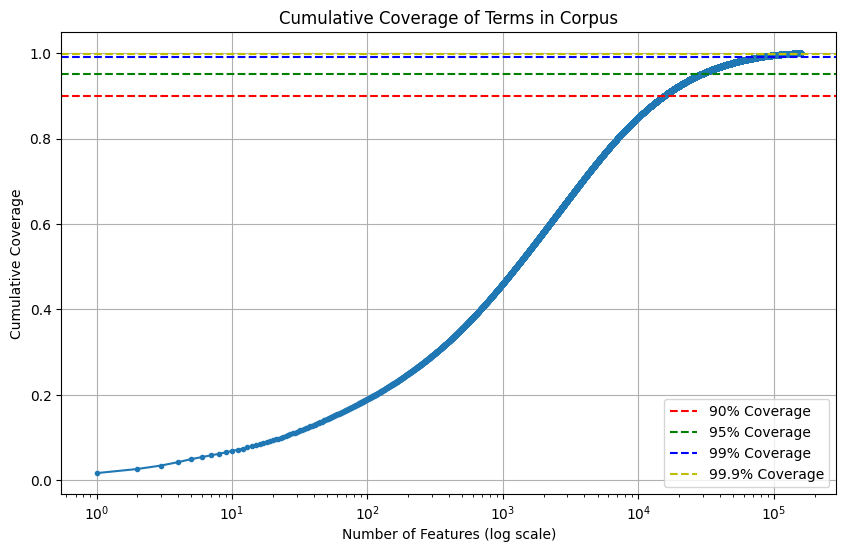

In [15]:
# Plot coverage curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(coverage) + 1), coverage, marker='.')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Coverage')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% Coverage')
plt.axhline(y=0.99, color='b', linestyle='--', label='99% Coverage')
plt.axhline(y=0.999, color='y', linestyle='--', label='99.9% Coverage')
plt.xscale('log')
plt.xlabel('Number of Features (log scale)')
plt.ylabel('Cumulative Coverage')
plt.title('Cumulative Coverage of Terms in Corpus')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
selecetd_max_features = 30_000

## Final vectorizer

In [16]:
if not os.path.exists(paths.X_TFIDF_JLIB):
	print("Creating X_tfidf from scratch...")
	# TF-IDF Vectorizer configuration
	tfidf = TfidfVectorizer(
		max_features=TFIDF_BEST_MAX_FEATURES,  	# Limits to top 30k features
		ngram_range=(1, 2),      				# Vocabulary including one-word and two-word terms (e.g., "climate", "climate change")
		stop_words="english",	 				# Removes common English stop words (e.g., "the", "is", "and")
		min_df=5,                				# Words must appear in at least 5 documents to be included
		max_df=0.7               				# Words that appear in more than 70% of documents are discarded
	)
	# Fit and transform the texts to obtain the TF-IDF matrix
	X_tfidf = tfidf.fit_transform(texts)
	print(X_tfidf.shape)
	# Save the fitted TF-IDF vectorizer to disk
	joblib.dump(tfidf, paths.MODEL_NOTEBOOKS_TFIDF)
	# Save the TF-IDF matrix to disk
	joblib.dump(X_tfidf, paths.X_TFIDF_JLIB)
else:
	tfidf = joblib.load(paths.MODEL_NOTEBOOKS_TFIDF)
	print("Loaded existing TF-IDF vectorizer from disk.")
	X_tfidf = joblib.load(paths.X_TFIDF_JLIB)
	print(f"Loaded existing X_tfidf with shape: {X_tfidf.shape} from disk.")

Loaded existing TF-IDF vectorizer from disk.
Loaded existing X_tfidf with shape: (89928, 30000) from disk.


In [17]:
# Get feature names (words)
feature_names = tfidf.get_feature_names_out()
feature_names

array(['00', '00 bst', '00 et', ..., 'zucker', 'zuckerberg', 'zverev'],
      shape=(30000,), dtype=object)

# 3) Dimension reduction with Truncated SVD

In [18]:
"""
Each dimension fixed by n_components in Truncated SVD represents a latent topic (LSA).
Latent topics are linear combinations of the original features that capture underlying themes in the data.
This allow us to reduce dimensionality of the data, passing from thousands of words to a few hundred topics,
which will make subsequent clustering more efficient and potentially more meaningful.
"""

'\nEach dimension fixed by n_components in Truncated SVD represents a latent topic (LSA).\nLatent topics are linear combinations of the original features that capture underlying themes in the data.\nThis allow us to reduce dimensionality of the data, passing from thousands of words to a few hundred topics,\nwhich will make subsequent clustering more efficient and potentially more meaningful.\n'

## Search for best hyperparameters

### Helper functions

In [19]:
def calculate_explained_variance(
	n_components_list: list[int],
	X_tfidf: np.ndarray,
	df_variance: pd.DataFrame | None = None,
	save_csv: bool = True,
	random_state: int = RANDOM_SEED
):
	
	# Initialize DataFrame if not provided
	if df_variance is None:
		if os.path.exists(paths.DF_VARIANCE):
			df_variance = pd.read_csv(paths.DF_VARIANCE)
		else:
			df_variance = pd.DataFrame(columns=["n_components", "explained_variance"])
	
	# Filter out n_components already evaluated
	existing = set(df_variance["n_components"].astype(int).tolist()) if not df_variance.empty else set()
	n_components_list = [k for k in n_components_list if k not in existing]

	if not n_components_list:
		return df_variance

	# Fit Truncated SVD with the maximum n_components needed
	svd = TruncatedSVD(
		n_components=max(n_components_list),
		random_state=random_state
	)

	# Fit SVD on the TF-IDF matrix
	print(f"Fitting Truncated SVD with n_components={max(n_components_list)}...")
	svd.fit(X_tfidf)
	
	# Calculate cumulative explained variance
	cum_exp_var = np.cumsum(svd.explained_variance_ratio_)
	
	# Collect results for specified n_components
	n_components = []
	explained_variances = []
	for k in n_components_list:
		ev = float(cum_exp_var[k - 1])
		n_components.append(k)
		explained_variances.append(ev)

	# Create DataFrame for new results
	df_results = pd.DataFrame({
		"n_components": n_components,
		"explained_variance": explained_variances
	})

	# Append new results to existing DataFrame
	df_variance = pd.concat([df_variance, df_results], ignore_index=True)

	# Sort by explained_variance
	df_variance = df_variance.sort_values(by="explained_variance", ascending=False).reset_index(drop=True)

	# Save to CSV if required
	if save_csv:
		df_variance.to_csv(paths.DF_VARIANCE, index=False)

	clear_output(wait=True)

	return df_variance	

In [20]:
def plot_explained_variance(
	df_variance: pd.DataFrame,
	tfidf_max_features: int = TFIDF_BEST_MAX_FEATURES,
) -> None:
	# Plot explained variance vs n_components
	plt.figure(figsize=(10, 6))
	plt.plot(df_variance["n_components"], df_variance["explained_variance"], marker='o')
	plt.xlabel('Number of Components (n_components)')
	plt.ylabel('Explained Variance Ratio')
	plt.title(f'Explained Variance vs Number of Components in LSA\n(TF-IDF max features: {tfidf_max_features})')
	plt.grid(True)
	plt.show()

In [21]:
def create_fit_transform_svd_pipeline(
	n_components: int,
	X_tfidf: np.ndarray,
	random_state: int = RANDOM_SEED,
) -> np.ndarray:

	# Initialize Truncated SVD
	svd = TruncatedSVD(
	n_components=n_components,
	random_state=random_state
	)

	# Normalizer helps to make distances for K-means more stable
	normalizer = Normalizer(copy=False)
	normalizer

	# Create a pipeline that first applies SVD and then normalizes the result
	svd_pipeline = make_pipeline(svd, normalizer)
	svd_pipeline

	# Fit and transform the TF-IDF matrix to obtain the reduced representation
	X_reduced = svd_pipeline.fit_transform(X_tfidf)

	# Calculate explained variance
	explained_var = svd.explained_variance_ratio_.sum()

	print(f"SVD Pipeline created with n_components={n_components}")
	print(f"Reduced data shape: {X_reduced.shape}")
	print(f"Explained variance: {explained_var:.4f}")

	return X_reduced

### Experimentation

Loading existing explained variance df from disk...


,n_components,explained_variance
0,10000,0.859843
1,9000,0.839733
2,8000,0.815512
3,7000,0.786880
4,6000,0.752904
5,5000,0.709593
6,4500,0.687267
7,4000,0.661272
8,3500,0.631487
9,3000,0.597275


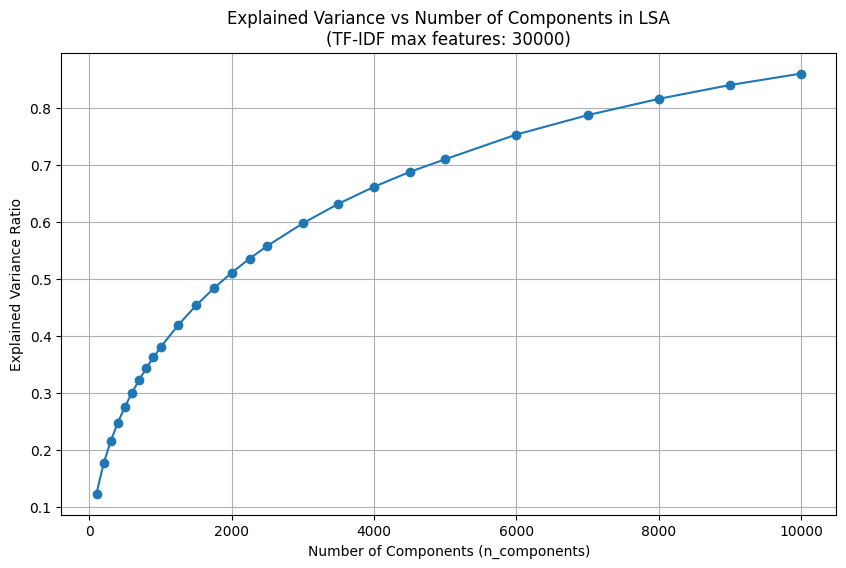

In [22]:
# If df_variance does not exist on disk, calculate it, otherwise load it
if not os.path.exists(paths.DF_VARIANCE):
	print("Calculating explained variance df for different n_components...")
	df_variance = pd.DataFrame(columns=["n_components", "explained_variance"])
	# Define the list of n_components values to evaluate
	n_components_list = (
		list(range(100, 1001, 100)) + 
		list(range(1250, 2501, 250)) + 
		list(range(3000, 5001, 500)) +
	)
	# Calculate and save on disk explained variance df for different values of n_components
	df_variance = calculate_explained_variance(n_components_list, X_tfidf, df_variance)
else:
	print("Loading existing explained variance df from disk...")
	df_variance = pd.read_csv(paths.DF_VARIANCE)
display(df_variance)
plot_explained_variance(df_variance, tfidf_max_features=TFIDF_BEST_MAX_FEATURES)

# 4) Clustering with K-Means

In [23]:
"""
Now we can cluster the news articles in this reduced dimensional space using
K-means clustering.
"""

'\nNow we can cluster the news articles in this reduced dimensional space using\nK-means clustering.\n'

## Search for best hyperparameters

### Helper functions

In [24]:
def evaluate_k(
	k_values,
	X,
	df_silhouette: pd.DataFrame | None = None,
	silhouette_sample_size: int | None = 1_000,
	n_jobs: int = -1,
	# kmeans_algorithm: str = "elkan",
):
	"""
	Trains K-means for each k in k_values and computes the silhouette score.
	Args:
		k_values (list): List of k values to evaluate.
		X (array-like): Data to cluster.
		df_silhouette (pd.DataFrame): DataFrame to append results to.
	Returns:
		results (list): List of dicts with k and silhouette score.
	"""

	if df_silhouette is None:
		if os.path.exists(paths.DF_SILHOUETTE):
			df_silhouette = pd.read_csv(paths.DF_SILHOUETTE)
		else:
			df_silhouette = pd.DataFrame(columns=["k", "silhouette", "inertia"])

	X_arr = np.asarray(X, dtype=np.float32)

	# Check for already evaluated k values and skip them
	existing = set(df_silhouette["k"].astype(int).tolist()) if len(df_silhouette) else set()
	k_values_to_run = [int(k) for k in k_values if int(k) not in existing]

	def _run_one_k(k: int) -> dict:
		
		# Limit internal OpenMP threads to 1 per process to avoid oversubscription
		with threadpool_limits(limits=1):
			
			# Initialize MiniBatchKMeans with specified parameters
			km = MiniBatchKMeans(
				n_clusters=k,
				init="k-means++",
				n_init="auto",
				max_iter=300,
				batch_size=2048,
				# algorithm=kmeans_algorithm,
				random_state=RANDOM_SEED,
			)

			# Fit K-means and predict cluster labels
			print(f"Fitting K-means for k={k}...")
			labels = km.fit_predict(X_arr)

			# Compute silhouette score
			print(f"Computing silhouette score for k={k}...")
			sil = silhouette_score(
				X_arr,
				labels,
				sample_size=silhouette_sample_size,
				random_state=RANDOM_SEED,
			)
			# Get inertia
			inertia = float(km.inertia_)

		# print(f"Evaluated k={k}: silhouette={sil:.4f}, inertia={inertia:.4f}")
		
		return {"k": k, "silhouette": float(sil), "inertia": inertia}

	if k_values_to_run:
		# Run evaluations in parallel
		results = Parallel(n_jobs=n_jobs, prefer="processes")(
			delayed(_run_one_k)(k) for k in k_values_to_run
		)

		# Append new results to the DataFrame
		df_silhouette = pd.concat([df_silhouette, pd.DataFrame(results)], ignore_index=True)

	# Order by silhouette descending
	df_silhouette = df_silhouette.sort_values(by="silhouette", ascending=False).reset_index(drop=True)

	# # Summary
	# for _, row in df_silhouette.iterrows():
	# 	print(f"k={int(row['k'])}, silhouette={row['silhouette']:.4f}, inertia={row['inertia']:.4f}")

	clear_output(wait=True)

	return df_silhouette

In [25]:
def plot_silhouette_inertia(
	df_silhouette: pd.DataFrame,
	tfidf_max_features: int = TFIDF_BEST_MAX_FEATURES,
	svd_n_components: int = SVD_BEST_N_COMPONENTS,
) -> None:
	"""
	Plots inertia and silhouette score vs number of clusters (k) with two y-axes.
	Args:
		df_silhouette (pd.DataFrame): DataFrame with k, silhouette, and inertia columns.
		tfidf_max_features (int): Number of TF-IDF features used.
		svd_n_components (int): Number of SVD components used.
	Returns:
		None
	"""

	# Reorder by k ascending
	df_silhouette = df_silhouette.sort_values(by="k").reset_index(drop=True)

	# Create figure and axis objects
	fig, ax1 = plt.subplots(figsize=(10, 5))

	# First axis Y (left)
	ax1.plot(df_silhouette["k"], df_silhouette["inertia"], marker="o", color="b", label="Inertia")
	ax1.set_xlabel("k")
	ax1.set_ylabel("Inertia", color="b")
	ax1.grid(True, alpha=0.3)

	# Second axis Y (right)
	ax2 = ax1.twinx()
	ax2.plot(df_silhouette["k"], df_silhouette["silhouette"], marker="o", linestyle="--", color="r", label="Silhouette Score")
	ax2.set_ylabel("Silhouette Score", color="r")

	# Combined legend (from both axes)
	lines1, labels1 = ax1.get_legend_handles_labels()
	lines2, labels2 = ax2.get_legend_handles_labels()
	ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

	plt.title(f"Inertia and Silhouette Score vs Number of Clusters (k)\n(TF-IDF max features: {tfidf_max_features}, SVD components: {svd_n_components})")
	plt.tight_layout()
	plt.show()

In [26]:
def get_X_reduced(n_components):
	"""
	Compute (or load from disk) SVD reductor and X_reduced for n_components=5000
	"""

	# Load existing X_reduced_dict if it exists, otherwise initialize an empty dict
	if not os.path.exists(paths.X_REDUCED_DICT_JLIB):
		X_reduced_dict = {}
	else:
		X_reduced_dict = joblib.load(paths.X_REDUCED_DICT_JLIB)
		print(f"Loaded existing X_reduced_dict with keys n_components: {list(X_reduced_dict.keys())}")
	# Check if n_components is already in the dictionary, if not, create, fit and transform SVD pipeline
	if X_reduced_dict.get(n_components) is None:
		# Create, fit and transform SVD pipeline for n_components
		X_reduced_dict[n_components] = create_fit_transform_svd_pipeline(n_components, X_tfidf)
		# Save the updated dictionary to disk
		joblib.dump(X_reduced_dict, paths.X_REDUCED_DICT_JLIB)
	return X_reduced_dict[n_components]

In [27]:
def get_df_silhouette(
	svd_n_components=SVD_BEST_N_COMPONENTS,
	X_reduced=None,
):
	# Load existing df_silhouette_dict if it exists, otherwise initialize an empty dict
	if not os.path.exists(paths.DF_SILHOUETTE_DICT_JLIB):
		df_silhouette_dict = {}
	else:
		df_silhouette_dict = joblib.load(paths.DF_SILHOUETTE_DICT_JLIB)
		print(f"Loaded existing df_silhouette_dict with keys svd_n_components: {list(df_silhouette_dict.keys())}")
	# Define k values to evaluate
	k_values = list(range(2, 99, 2)) + list(range(100, 201, 5))
	# Evaluate k values for the selected svd_n_components
	df_silhouette_dict[svd_n_components] = evaluate_k(
		k_values,
		X_reduced,
		df_silhouette_dict.get(svd_n_components, pd.DataFrame())
	)
	# Save the updated dictionary to disk
	joblib.dump(df_silhouette_dict, paths.DF_SILHOUETTE_DICT_JLIB)
	
	return df_silhouette_dict[svd_n_components]

### Experimentation

#### n_components = 5000

,k,silhouette,inertia
0,115,0.021492,80256.101562
1,92,0.020198,80489.320312
2,105,0.019303,80202.546875
3,58,0.019252,81900.296875
4,135,0.019247,79778.382812
...,...,...,...
77,5,0.005520,86813.773438
78,7,0.005263,86469.609375
79,4,0.005165,86978.812500
80,3,0.004047,87479.523438


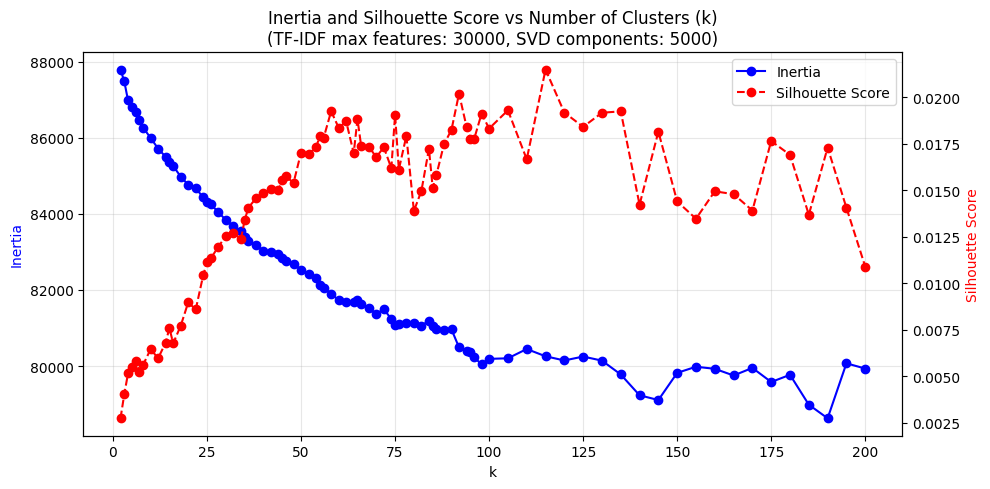

In [28]:
tfidf_max_features = 30_000
svd_n_components = 5_000
df_silhouette = get_df_silhouette(svd_n_components,	get_X_reduced(svd_n_components))
display(df_silhouette)
plot_silhouette_inertia(df_silhouette, tfidf_max_features, svd_n_components)

#### n_components = 500

,k,silhouette,inertia
0,290,0.085083,54128.109375
1,292,0.084890,54115.738281
2,456,0.084570,49812.589844
3,296,0.084330,53936.289062
4,284,0.083884,54807.601562
...,...,...,...
305,10,0.018679,80016.984375
306,6,0.018145,81557.984375
307,8,0.015483,80825.234375
308,4,0.014217,82602.804688


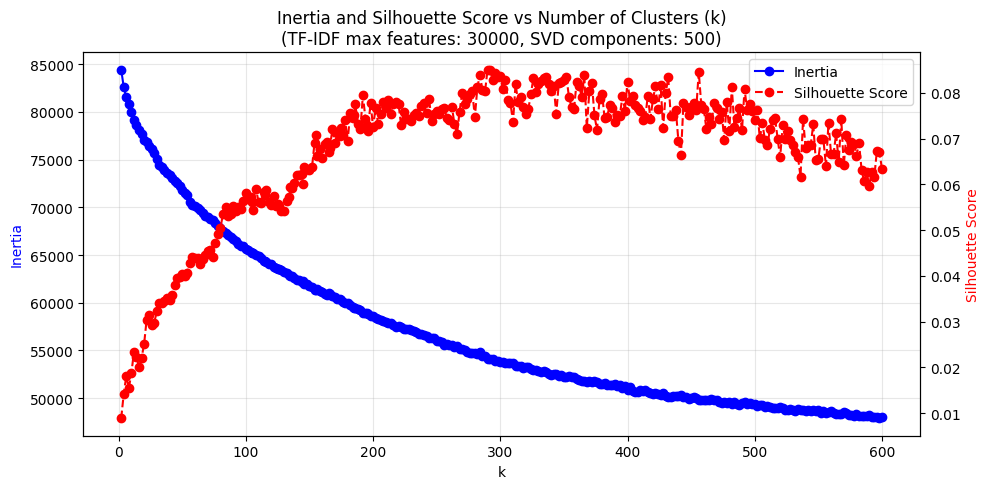

In [29]:
tfidf_max_features = 30_000
svd_n_components = 500
df_silhouette = get_df_silhouette(svd_n_components,	get_X_reduced(svd_n_components))
display(df_silhouette)
plot_silhouette_inertia(df_silhouette, tfidf_max_features, svd_n_components)

#### n_components = 100

,k,silhouette,inertia
0,88,0.162606,40515.222656
1,108,0.158598,38176.804688
2,110,0.158026,37960.527344
3,94,0.158020,39979.839844
4,86,0.157628,41097.785156
...,...,...,...
205,10,0.050753,66696.617188
206,6,0.043823,69717.460938
207,8,0.035942,69605.703125
208,4,0.032148,73667.328125


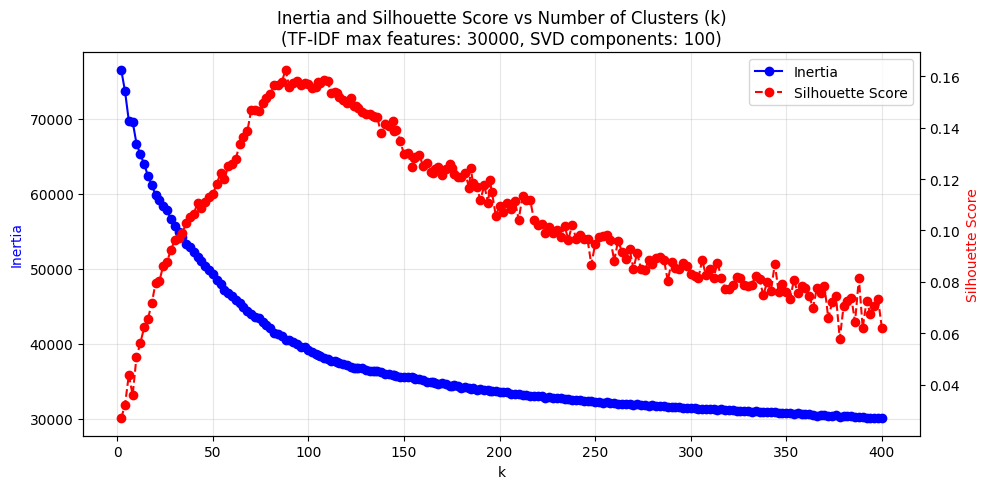

In [30]:
tfidf_max_features = 30_000
svd_n_components = 100
df_silhouette = get_df_silhouette(svd_n_components,	get_X_reduced(svd_n_components))
display(df_silhouette)
plot_silhouette_inertia(df_silhouette, tfidf_max_features, svd_n_components)

#### n_components = 50

,k,silhouette,inertia
0,48,0.163532,35781.957031
1,50,0.161550,35134.425781
2,44,0.159313,36888.449219
3,46,0.159213,36369.531250
4,42,0.158293,37576.792969
...,...,...,...
205,398,0.049022,22523.740234
206,348,0.048772,22974.593750
207,380,0.048388,22702.287109
208,384,0.048123,22648.369141


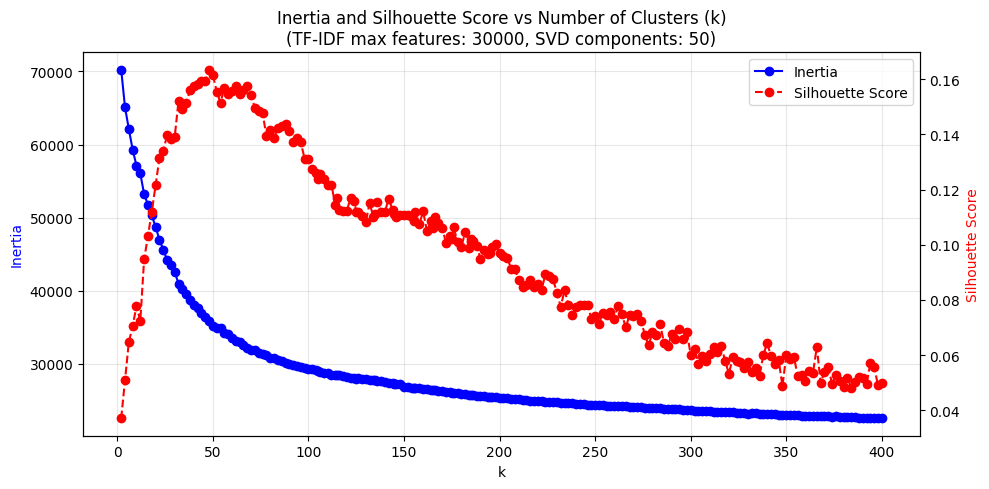

In [31]:
tfidf_max_features = 30_000
svd_n_components = 50
df_silhouette = get_df_silhouette(svd_n_components,	get_X_reduced(svd_n_components))
display(df_silhouette)
plot_silhouette_inertia(df_silhouette, tfidf_max_features, svd_n_components)

#### n_components = 5

,k,silhouette,inertia
0,5,0.366919,12328.489258
1,4,0.360303,16438.980469
2,6,0.343088,10685.608398
3,8,0.327637,8817.355469
4,7,0.302005,10107.304688
...,...,...,...
217,386,0.051443,1211.795898
218,376,0.051250,1232.835815
219,366,0.049026,1250.275513
220,372,0.044735,1237.747070


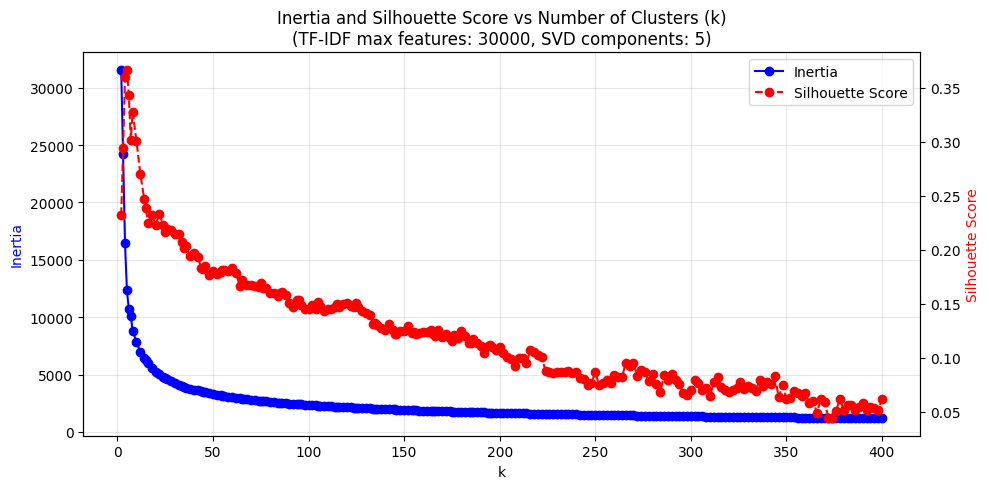

In [32]:
tfidf_max_features = 30_000
svd_n_components = 5
df_silhouette = get_df_silhouette(svd_n_components,	get_X_reduced(svd_n_components))
display(df_silhouette)
plot_silhouette_inertia(df_silhouette, tfidf_max_features, svd_n_components)

#### n_components = 25

,k,silhouette,inertia
0,24,0.217422,28874.181641
1,22,0.214083,30328.257812
2,34,0.210339,25576.197266
3,26,0.209962,27998.019531
4,32,0.207443,25855.925781
...,...,...,...
65,185,0.071668,16780.343750
66,195,0.065809,16662.339844
67,190,0.061775,16785.787109
68,200,0.061514,16602.224609


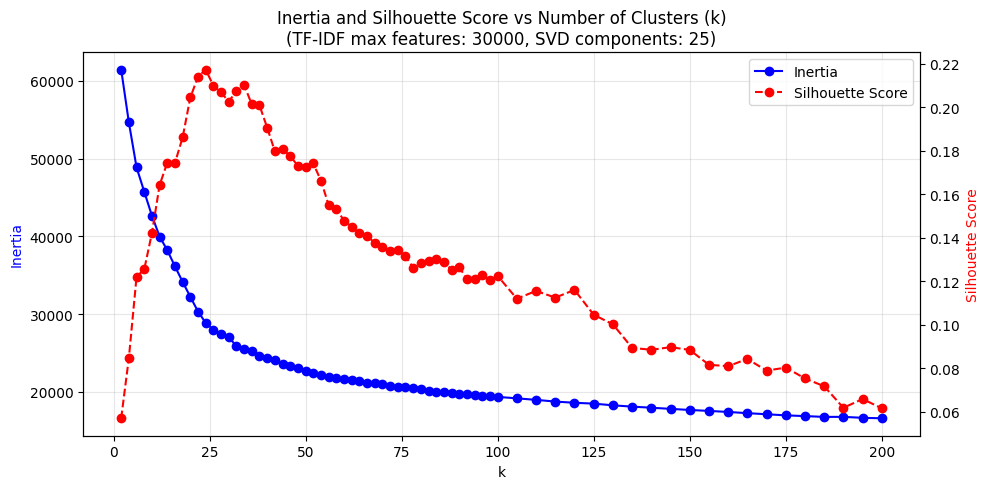

In [33]:
tfidf_max_features = 30_000
svd_n_components = 25
df_silhouette = get_df_silhouette(svd_n_components,	get_X_reduced(svd_n_components))
display(df_silhouette)
plot_silhouette_inertia(df_silhouette, tfidf_max_features, svd_n_components)

# 5) Compare configurations - global scorecard

## Helper functions

In [34]:
def safe_z(x: np.ndarray) -> np.ndarray:
	x = np.asarray(x, dtype=float)
	std = x.std(ddof=0)
	if std < 1e-12:
		return np.zeros_like(x)
	return (x - x.mean()) / std

In [35]:
def top_terms_for_cluster(X_tfidf, labels, topic_id, feature_names, n_terms=20):
	idx = np.where(labels == topic_id)[0]
	if len(idx) == 0:
		return []
	X_cluster = X_tfidf[idx]
	tfidf_mean = np.asarray(X_cluster.mean(axis=0)).ravel()
	top_idx = tfidf_mean.argsort()[::-1][:n_terms]
	return [feature_names[i] for i in top_idx]

In [36]:
def build_df_topics_for_config(
	X_tfidf,
	X_reduced,
	labels,
	centers,
	feature_names,
	dictionary: Dictionary,
	corpus,
	tokenized_texts,
	n_top_terms=20,
) -> pd.DataFrame:
	k = int(labels.max()) + 1

	# Sizes
	sizes = np.bincount(labels, minlength=k)

	# Distances to centroid (mean per topic)
	dist_centroid = np.zeros(k, dtype=float)
	for t in range(k):
		idx = np.where(labels == t)[0]
		if len(idx) == 0:
			dist_centroid[t] = np.nan
			continue
		d = np.linalg.norm(X_reduced[idx] - centers[t], axis=1)
		dist_centroid[t] = float(d.mean())

	# Topic top terms
	topics_terms = []
	for t in range(k):
		terms = top_terms_for_cluster(
			X_tfidf=X_tfidf,
			labels=labels,
			topic_id=t,
			feature_names=feature_names,
			n_terms=n_top_terms
		)
		# Keep only terms that exist in the Dictionary (defensive)
		terms = [w for w in terms if w in dictionary.token2id]
		topics_terms.append(terms)

	# Coherence per topic (c_npmi and u_mass)
	# c_npmi uses texts + dictionary; u_mass uses corpus + dictionary
	cm_npmi = CoherenceModel(
		topics=topics_terms,
		texts=tokenized_texts,
		dictionary=dictionary,
		coherence="c_npmi"
	)
	c_npmi = np.array(cm_npmi.get_coherence_per_topic(), dtype=float)

	cm_umass = CoherenceModel(
		topics=topics_terms,
		corpus=corpus,
		dictionary=dictionary,
		coherence="u_mass"
	)
	u_mass = np.array(cm_umass.get_coherence_per_topic(), dtype=float)

	df = pd.DataFrame({
		"id_topic": np.arange(k),
		"size": sizes,
		"top_terms": topics_terms,
		"c_npmi": c_npmi,
		"u_mass": u_mass,
		"dist_centroid": dist_centroid,
	})

	# Flags based on size percentiles (as you specified)
	p10 = df["size"].quantile(0.10)
	p90 = df["size"].quantile(0.90)
	df["flag_small"] = df["size"] <= p10
	df["flag_big"] = df["size"] >= p90

	# A/B/C buckets
	# We build a simple composite score (higher better):
	# - reward coherence (c_npmi, u_mass)
	# - penalize looseness (dist_centroid)
	# - penalize very small / very big topics a bit
	score = (
		safe_z(df["c_npmi"].values)
		+ 0.7 * safe_z(df["u_mass"].values)      # u_mass: higher (less negative) is better
		- 0.7 * safe_z(df["dist_centroid"].values)
		- 0.4 * df["flag_small"].astype(float).values
		- 0.2 * df["flag_big"].astype(float).values
	)
	q1 = np.quantile(score, 1/3)
	q2 = np.quantile(score, 2/3)

	df["quality_bucket"] = np.where(score >= q2, "A",
							 np.where(score >= q1, "B", "C"))

	return df

In [ ]:
def run_grid(
	texts_sub,
	tfidf_params: dict,
	n_components_grid,
	n_clusters_grid,
	n_top_terms=20,
) -> pd.DataFrame:
	# Fit TF-IDF once
	tfidf = TfidfVectorizer(**tfidf_params)
	X_tfidf = tfidf.fit_transform(texts_sub)
	feature_names = tfidf.get_feature_names_out()

	# Tokenize once using the TF-IDF analyzer (critical: consistent with ngrams/stopwords)
	analyzer = tfidf.build_analyzer()
	tokenized_texts = [analyzer(t) for t in texts_sub]

	# Build dictionary/corpus once
	dictionary = Dictionary(tokenized_texts)
	corpus = [dictionary.doc2bow(doc) for doc in tokenized_texts]

	# rows = []
	dfs = []

	for n_components in n_components_grid:
		svd = TruncatedSVD(n_components=n_components, random_state=RANDOM_SEED)
		print(f"Fitting SVD with n_components={n_components}...")
		X_reduced = svd.fit_transform(X_tfidf)

		for k in n_clusters_grid:
			kmeans = MiniBatchKMeans(
				n_clusters=k,
				random_state=RANDOM_SEED,
				n_init=1,
				max_iter=100,
				batch_size=2048,
			)
			print(f"\tFitting KMeans with n_clusters={k}...")
			labels = kmeans.fit_predict(X_reduced)
			centers = kmeans.cluster_centers_

			df_topics = build_df_topics_for_config(
				X_tfidf=X_tfidf,
				X_reduced=X_reduced,
				labels=labels,
				centers=centers,
				feature_names=feature_names,
				dictionary=dictionary,
				corpus=corpus,
				tokenized_texts=tokenized_texts,
				n_top_terms=n_top_terms,
			)

			df_topics["n_components"] = n_components
			df_topics["n_clusters"] = k
			df_topics.insert(0, "n_clusters", df_topics.pop("n_clusters"))
			df_topics.insert(0, "n_components", df_topics.pop("n_components"))
			dfs.append(df_topics)
			
	df_all_topics = pd.concat(dfs, ignore_index=True)

	# Save to disk
	df_all_topics.to_parquet(paths.DF_ALL_TOPICS_AND_CONFIGS, index=False)

	clear_output(wait=True)

	return df_all_topics

In [40]:
def robust_z_global(x, med, iqr, eps=1e-12):
	return (x - med) / (iqr + eps)

In [41]:
def compute_global_robust_params(df_all, col):
	med = df_all[col].median()
	q25 = df_all[col].quantile(0.25)
	q75 = df_all[col].quantile(0.75)
	iqr = q75 - q25
	return med, iqr

In [54]:
def enrich_df_all_topics(df_all_topics: pd.DataFrame) -> pd.DataFrame:
    # 1) Global params
	c_med, c_iqr = compute_global_robust_params(df_all_topics, "c_npmi")
	u_med, u_iqr = compute_global_robust_params(df_all_topics, "u_mass")
	d_med, d_iqr = compute_global_robust_params(df_all_topics, "dist_centroid")

	# 2) Global z-scores
	z_c = robust_z_global(df_all_topics["c_npmi"], c_med, c_iqr)
	z_u = robust_z_global(df_all_topics["u_mass"], u_med, u_iqr)  # higher is better (less negative)
	z_d = robust_z_global(df_all_topics["dist_centroid"], d_med, d_iqr)  # higher is worse

	# 3) score global
	df_all_topics["score_global"] = (
		z_c
		+ 0.7 * z_u
		- 0.7 * z_d
		- 0.4 * df_all_topics["flag_small"].astype(float)
		- 0.2 * df_all_topics["flag_big"].astype(float)
	)

	# Standardize score_global
	score_mean = df_all_topics["score_global"].mean()
	score_std = df_all_topics["score_global"].std(ddof=0)
	df_all_topics["score_global_z"] = (df_all_topics["score_global"] - score_mean) / score_std

	# Standardize score_global within each config
	df_all_topics["score_config_z"] = df_all_topics.groupby(
		["n_components", "n_clusters"]
	)["score_global"].transform(lambda x: (x - x.mean()) / x.std(ddof=0))

	# Add global z_scores for the rest of the metrics to df_all_topics
	df_all_topics["c_npmi_z_global"] = z_c
	df_all_topics["u_mass_z_global"] = z_u
	df_all_topics["dist_centroid_z_global"] = z_d
	df_all_topics["size_z_global"] = safe_z(df_all_topics["size"].values)

	# Add config-level z_scores for the rest of the metrics to df_all_topics
	df_all_topics["c_npmi_z_config"] = df_all_topics.groupby(
		["n_components", "n_clusters"]
	)["c_npmi"].transform(lambda x: (x - x.mean()) / x.std(ddof=0))
	df_all_topics["u_mass_z_config"] = df_all_topics.groupby(
		["n_components", "n_clusters"]
	)["u_mass"].transform(lambda x: (x - x.mean()) / x.std(ddof=0))
	df_all_topics["dist_centroid_z_config"] = df_all_topics.groupby(
		["n_components", "n_clusters"]
	)["dist_centroid"].transform(lambda x: (x - x.mean()) / x.std(ddof=0))
	df_all_topics["size_z_config"] = df_all_topics.groupby(
		["n_components", "n_clusters"]
	)["size"].transform(lambda x: (x - x.mean()) / x.std(ddof=0))

	q1 = df_all_topics["score_global"].quantile(1/3)
	q2 = df_all_topics["score_global"].quantile(2/3)

	df_all_topics["quality_bucket"] = np.where(
		df_all_topics["score_global"] >= q2, "A",
		np.where(df_all_topics["score_global"] >= q1, "B", "C")
	)

	cols_order = ["n_components", "n_clusters", "id_topic", "top_terms", "quality_bucket", "score_global", "score_global_z",
			  "score_config_z", "size", "size_z_global", "size_z_config", "flag_small", "flag_big", "c_npmi",
			  "c_npmi_z_global", "c_npmi_z_config", "u_mass", "u_mass_z_global", "u_mass_z_config", "dist_centroid",
			  "dist_centroid_z_global", "dist_centroid_z_config"]
	df_all_topics = df_all_topics[cols_order]
	
	return df_all_topics

## Experimentation

In [ ]:
N_COMPONENTS_GRID = list(range(30, 151, 10))
N_CLUSTERS_GRID = list(range(30, 101, 10))
# N_SUBSAMPLE = 20_000
N_SUBSAMPLE = len(texts)

tfidf_params = dict(
	min_df=5,
	max_df=0.7,
	ngram_range=(1, 2),
	max_features=TFIDF_BEST_MAX_FEATURES,
	dtype=np.float32,
	stop_words="english",
)

In [60]:
df_subsample = df_train.sample(n=min(N_SUBSAMPLE, len(df_train)), random_state=RANDOM_SEED)
texts_subsample = df_subsample["text"].astype(str).tolist()
len(texts_subsample)

20000

In [61]:
df_all_topics = run_grid(
	texts_sub=texts_subsample,
	tfidf_params=tfidf_params,
	n_components_grid=N_COMPONENTS_GRID,
	n_clusters_grid=N_CLUSTERS_GRID,
	n_top_terms=50,
)
df_all_topics

,n_components,n_clusters,id_topic,size,top_terms,c_npmi,u_mass,dist_centroid,flag_small,flag_big,quality_bucket
0,30,30,0,389,"[election, voting, voters, georgia, state, tru...",0.201136,-1.332068,0.183759,False,False,A
1,30,30,1,5007,"[new, says, said, people, reports, year, cbsn,...",0.049252,-1.925307,0.100175,False,True,A
2,30,30,2,299,"[trump, president, election, capitol, impeachm...",0.157589,-1.572375,0.205734,False,False,B
3,30,30,3,221,"[variant, omicron, delta, vaccinated, fauci, d...",-0.043337,-8.927068,0.332050,True,False,C
4,30,30,4,1022,"[police, said, officers, officer, man, shootin...",0.131056,-1.728429,0.154780,False,False,A
...,...,...,...,...,...,...,...,...,...,...,...
235,40,50,45,462,"[trump, president, donald, donald trump, impea...",0.080218,-1.696260,0.189368,False,False,B
236,40,50,46,240,"[activist post, freedom, peace freedom, activi...",0.016704,-0.488660,0.188835,False,False,A
237,40,50,47,457,"[said, water, storm, weather, north, state, pe...",0.098514,-2.225674,0.164331,False,False,B
238,40,50,48,140,"[gun, gun control, control, guns, firearms, se...",0.003555,-1.443781,0.181653,False,False,B


In [62]:
df_all_topics_enriched = enrich_df_all_topics(df_all_topics)
df_all_topics_enriched

,n_components,n_clusters,id_topic,top_terms,quality_bucket,score_global,score_global_z,score_config_z,size,size_z_global,...,flag_big,c_npmi,c_npmi_z_global,c_npmi_z_config,u_mass,u_mass_z_global,u_mass_z_config,dist_centroid,dist_centroid_z_global,dist_centroid_z_config
0,30,30,0,"[election, voting, voters, georgia, state, tru...",A,1.687333,0.963639,0.682199,389,-0.165687,...,False,0.201136,1.145465,1.686850,-1.332068,0.852977,0.463370,0.183759,0.078880,0.138506
1,30,30,1,"[new, says, said, people, reports, year, cbsn,...",B,0.286545,0.205650,0.285662,5007,6.727485,...,True,0.049252,-0.330252,-0.458155,-1.925307,-0.606633,0.087344,0.100175,-1.773485,-2.025245
2,30,30,2,"[trump, president, election, capitol, impeachm...",A,0.509439,0.326262,0.348759,299,-0.300028,...,False,0.157589,0.722355,1.071845,-1.572375,0.261726,0.311051,0.205734,0.565891,0.707385
3,30,30,3,"[variant, omicron, delta, vaccinated, fauci, d...",C,-16.469223,-8.861155,-4.457586,221,-0.416456,...,False,-0.043337,-1.229846,-1.765746,-8.927068,-17.833830,-4.350737,0.332050,3.365279,3.977357
4,30,30,4,"[police, said, officers, officer, man, shootin...",A,0.773333,0.469059,0.423463,1022,0.779176,...,False,0.131056,0.464559,0.697129,-1.728429,-0.122232,0.212136,0.154780,-0.563337,-0.611669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,40,50,45,"[trump, president, donald, donald trump, impea...",B,-0.201768,-0.058583,0.012007,462,-0.056722,...,False,0.080218,-0.029383,-0.051071,-1.696260,-0.043083,0.107207,0.189368,0.203181,0.189688
236,40,50,46,"[activist post, freedom, peace freedom, activi...",A,1.269229,0.737396,0.980648,240,-0.388095,...,False,0.016704,-0.646481,-0.825415,-0.488660,2.928108,2.350233,0.188835,0.191379,0.174091
237,40,50,47,"[said, water, storm, weather, north, state, pe...",C,-0.547415,-0.245618,-0.215599,457,-0.064185,...,False,0.098514,0.148379,0.171988,-2.225674,-1.345657,-0.876139,0.164331,-0.351666,-0.543575
238,40,50,48,"[gun, gun control, control, guns, firearms, se...",B,-0.392112,-0.161581,-0.113334,140,-0.537363,...,False,0.003555,-0.774241,-0.985729,-1.443781,0.578118,0.576167,0.181653,0.032221,-0.036246


In [63]:
df_scorecard = (
	df_all_topics_enriched
	.groupby(["n_components", "n_clusters"])
	.agg(
		c_npmi_mean=("c_npmi", "mean"),
		u_mass_mean=("u_mass", "mean"),
		dist_mean=("dist_centroid", "mean"),
		score_mean=("score_global", "mean"),
		bucket_A_rate=("quality_bucket", lambda s: (s=="A").mean()),
		bucket_B_rate=("quality_bucket", lambda s: (s=="B").mean()),
		bucket_C_rate=("quality_bucket", lambda s: (s=="C").mean()),
	)
	.reset_index()
	.sort_values(["bucket_A_rate", "score_mean"], ascending=False)
)
df_scorecard

,n_components,n_clusters,c_npmi_mean,u_mass_mean,dist_mean,score_mean,bucket_A_rate,bucket_B_rate,bucket_C_rate
2,30,50,0.094539,-1.687370,0.158157,0.376865,0.480000,0.360,0.160000
1,30,40,0.089190,-1.728601,0.166820,0.119504,0.425000,0.325,0.250000
0,30,30,0.081693,-2.063106,0.178408,-0.722571,0.300000,0.400,0.300000
3,40,30,0.078373,-1.608765,0.196115,-0.233663,0.266667,0.300,0.433333
4,40,40,0.092459,-1.702397,0.189756,-0.159434,0.250000,0.350,0.400000
5,40,50,0.084407,-1.753978,0.182891,-0.220001,0.240000,0.280,0.480000


In [ ]:
selected_n_components = 30
selected_n_clusters = 50

# 6) Final model

In [ ]:
# Build final pipeline with best hyperparameters found
final_pipeline = Pipeline([
	("tfidf", TfidfVectorizer(
		max_features=TFIDF_BEST_MAX_FEATURES,
		min_df=TFIDF_BEST_MIN_DF,
		max_df=TFIDF_BEST_MAX_DF,
		ngram_range=TFIDF_BEST_NGRAM_RANGE,
		dtype=np.float32,
	)),
	("svd", TruncatedSVD(
		n_components=SVD_BEST_N_COMPONENTS,
		random_state=RANDOM_SEED,
	)),
	("cluster", KMeans(
		n_clusters=KMEANS_BEST_N_CLUSTERS,
		init="k-means++",
		n_init=10,
		random_state=RANDOM_SEED,
	)),
])

# Fit the pipeline on the full dataset (includes TF-IDF, SVD, and K-means)
print(f"Fitting pipeline with TF-IDF max_features={TFIDF_BEST_MAX_FEATURES}, SVD n_components={SVD_BEST_N_COMPONENTS}, K-means n_clusters={KMEANS_BEST_N_CLUSTERS}...")
final_pipeline.fit(texts)

# Get the reduced representation of the full dataset (output of SVD)
X_reduced = final_pipeline[:-1].transform(texts)

# Get cluster labels
cluster_labels = final_pipeline.named_steps["cluster"].labels_

# Compute silhouette score on the full dataset
final_silhouette = silhouette_score(X_reduced, cluster_labels)
print(f"Final silhouette score on full dataset: {final_silhouette:.4f}")

# Save final pipeline to disk
joblib.dump(final_pipeline, paths.MODEL_NOTEBOOKS_PIPELINE)
print(f"Final pipeline saved to {paths.MODEL_NOTEBOOKS_PIPELINE}")

Fitting pipeline with TF-IDF max_features=30000, SVD n_components=30, K-means n_clusters=50...


Final silhouette score on full dataset: 0.1258
Final pipeline saved to /home/ruben/news-topics-ner/notebooks/models/model_pipeline.joblib


# 7) Enrich dataframes with metrics

## df_train

### Add cluster labels

In [ ]:
# Assign cluster labels to the original dataframe
df_train["id_topic"] = cluster_labels
df_train

,id_news,title,content,text,len_text,id_topic,dist_centroid,dist_centroid_z_score
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"Singer, activist Joan Baez becomes Kennedy Cen...",177,0,0.106435,-1.196037
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'Nothing but problems': Shipwreck tear-down en...,5332,46,0.130480,-1.266217
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,Report: At least 13 dead in Istanbul bombings....,248,0,0.160323,-0.398593
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,Senate Republicans Pressure Joe Biden to Withd...,4920,37,0.174631,-0.738630
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,The Unwelcome Return of the Real Purveyors of ...,3894,23,0.289562,1.292225
...,...,...,...,...,...,...,...,...
89923,89923,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,An Interview with Mark Blaxill on the Autism T...,1998,42,0.214257,0.740596
89924,89924,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,Vietnam reconsiders methane-emitting rice amid...,9005,15,0.207092,-0.092431
89925,89925,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,Shaker furniture: Clean by design. The Hancock...,262,26,0.081143,-1.412687
89926,89926,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",2093,13,0.151272,-0.785363


### Add distance to centroid for each point

In [ ]:
"""Compute distance to centroid for each document and add it as a new metric in df_train"""
# Get centroids
centroids = final_pipeline.named_steps["cluster"].cluster_centers_
# Calculate distances to centroids
distances = np.linalg.norm(X_reduced - centroids[cluster_labels], axis=1)
# Add distance to centroid metric to df_train
df_train["dist_centroid"] = distances

(50, 30)

In [ ]:
"""Compute z-score of distance to centroid within each cluster."""

# Compute per-cluster mean and std, then z-score per row
g = df_train.groupby("id_topic")["dist_centroid"]
df_train["dist_mean"] = g.transform("mean")
df_train["dist_std"]  = g.transform("std")  # sample std (ddof=1)

# Avoid division by zero when a cluster has std=0 (all distances identical)
df_train["dist_centroid_z_score"] = np.where(
	df_train["dist_std"] > 0,
	(df_train["dist_centroid"] - df_train["dist_mean"]) / df_train["dist_std"],
	0.0
)

# Remove intermediate columns
df_train.drop(columns=["dist_mean", "dist_std"], inplace=True)

df_train

,id_news,title,content,text,len_text,id_topic,dist_centroid,dist_centroid_z_score
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"Singer, activist Joan Baez becomes Kennedy Cen...",177,1,0.106435,-1.196037
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'Nothing but problems': Shipwreck tear-down en...,5332,47,0.130480,-1.266217
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,Report: At least 13 dead in Istanbul bombings....,248,1,0.160323,-0.398593
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,Senate Republicans Pressure Joe Biden to Withd...,4920,13,0.174631,-0.738630
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,The Unwelcome Return of the Real Purveyors of ...,3894,18,0.289562,1.292225
...,...,...,...,...,...,...,...,...
89923,89923,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,An Interview with Mark Blaxill on the Autism T...,1998,45,0.214257,0.740596
89924,89924,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,Vietnam reconsiders methane-emitting rice amid...,9005,21,0.207092,-0.092431
89925,89925,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,Shaker furniture: Clean by design. The Hancock...,262,25,0.081143,-1.412687
89926,89926,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",2093,47,0.151272,-0.785363


## df_topics

In [ ]:
df_topics = (
	df_all_topics[
		(df_all_topics["n_components"] == SVD_BEST_N_COMPONENTS) &
		(df_all_topics["n_clusters"] == KMEANS_BEST_N_CLUSTERS)
	]
	.drop(columns=["n_components", "n_clusters"])
	.reset_index(drop=True)
	.copy()
)
df_topics

,id_topic,top_terms,quality_bucket,score_global,score_global_z,score_config_z,size,size_z_global,size_z_config,flag_small,flag_big,c_npmi,c_npmi_z_global,c_npmi_z_config,u_mass,u_mass_z_global,u_mass_z_config,dist_centroid,dist_centroid_z_global,dist_centroid_z_config
0,0,"[said, state, city, people, million, workers, ...",A,1.214815,0.903888,0.330561,2225,0.375662,0.228244,False,False,0.095481,-0.061830,-0.292808,-1.370347,0.679074,0.604661,0.142271,-1.144705,-0.563368
1,1,"[cent, uk, bitcoin, market, year, said, prices...",A,0.840597,0.673021,0.043606,2798,0.631463,0.534932,False,False,0.140988,0.391201,0.307690,-2.061805,-0.649997,-0.657074,0.130044,-1.291992,-0.960837
2,2,"[vaccine, covid, covid 19, 19, vaccines, 19 va...",A,1.199277,0.894302,0.318646,1905,0.232806,0.056970,False,False,0.148918,0.470141,0.412325,-1.655481,0.131010,0.084365,0.161704,-0.910613,0.068351
3,3,"[police, officers, officer, said, shooting, ma...",B,-0.455753,-0.126739,-0.950454,2765,0.616731,0.517270,False,False,0.000312,-1.009255,-1.548627,-1.836573,-0.217073,-0.246084,0.153637,-1.007790,-0.193890
4,4,"[voting, election, voters, voting rights, stat...",A,1.087024,0.825049,0.232569,531,-0.380580,-0.678439,True,False,0.161623,0.596620,0.579974,-1.346916,0.724110,0.647416,0.191815,-0.547895,1.047183
5,5,"[gun, gun control, guns, control, firearms, se...",B,0.218290,0.289100,-0.433588,1217,-0.074333,-0.311269,False,False,0.046316,-0.551270,-0.941564,-1.464187,0.498700,0.433426,0.187434,-0.600672,0.904759
6,6,"[trump, president, donald, donald trump, elect...",A,0.690652,0.580515,-0.071374,2638,0.560035,0.449295,False,False,0.059334,-0.421676,-0.769786,-1.231689,0.945592,0.857676,0.183882,-0.643448,0.789323
7,7,"[said, bbc, prince, uk, time, people, says, ju...",A,0.579474,0.511926,-0.156627,5431,1.806896,1.944198,False,True,0.080315,-0.212808,-0.492930,-1.864188,-0.270153,-0.296474,0.097195,-1.687699,-2.028691
8,8,"[senate, democrats, infrastructure, manchin, h...",A,1.954357,1.360135,0.897652,690,-0.309598,-0.593337,False,False,0.238389,1.360832,1.592944,-1.654919,0.132090,0.085390,0.177876,-0.715803,0.594067
9,9,"[biden, tax, infrastructure, plan, democrats, ...",A,1.263273,0.933783,0.367719,851,-0.237724,-0.507164,False,False,0.180141,0.780975,0.824339,-1.754196,-0.058733,-0.095765,0.175226,-0.747729,0.507911


# 9) Automatic naming of clusters

In [227]:
# Load environment variables from .env file
load_dotenv(paths.ENV_FILE)

True

In [228]:
system_prompt=load_prompt_from_yaml(paths.PROMPTS_FILE, module="topics_namer_2")
system_prompt

'In the next user prompt, you will receive a json whose keys are cluster ids and its values are two dictionaries: "terms" and "news_texts".\n"terms" contains a list the most relevant words for that cluster, and "news_texts" contains a list of several news article texts related to that cluster, to help you understand its context.\nYour task is to generate a concise and descriptive label for each cluster based on the words and texts provided.\nThe labels should accurately reflect the common theme or topic represented by the words in each cluster.\nThe labels should be brief, ideally consisting of one to three words, and should avoid using overly generic terms. Focus on capturing the essence of the cluster in a way that is informative and specific.\nAlways answer in English and use title case for the labels (e.g., "Climate Change", "Artificial Intelligence").\nOutput the results as a JSON object where each key is the original cluster id and each value is the generated label for that clust

In [ ]:
# Select the top 3 representative articles per topic (closest to centroid)
df_best_texts = (
	df_train[["id_topic", "text", "len_text", "dist_centroid"]]
	.sort_values(["id_topic", "dist_centroid"], ascending=[True, True])
	.groupby("id_topic", as_index=False)
	.head(3)
	.copy()
)
df_best_texts

,id_topic,text,len_text,dist_centroid
77219,0,"Report: French clergy sexually abused 216,000 ...",243,0.075835
65864,0,FAA reportedly set to issue tight drone restri...,247,0.078939
75163,0,1959: Fidel Castro on American tourism. From t...,163,0.079762
40658,1,"Lin-Manuel Miranda on ""In the Heights,"" a movi...",7379,0.104806
20431,1,Tyson Fury v Deontay Wilder III: Is the Gypsy ...,4942,0.112682
...,...,...,...,...
59106,48,The coming crisis for QAnon: Can it survive an...,6420,0.136856
82379,48,WATCH: These Social Activists Don’t Just Ignor...,3526,0.140807
51073,49,Antonio Conte: Tottenham appoint former Chelse...,3347,0.078306
53039,49,Has Bruce stopped the rot at Newcastle and doe...,5265,0.086245


In [220]:
# Truncate texts to fit within token limits
MAX_LEN_TEXT = 7500
df_best_texts["text"] = df_best_texts["text"].str.slice(0, MAX_LEN_TEXT)
df_best_texts["len_text"] = df_best_texts["text"].str.len()
df_best_texts

,id_topic,text,len_text,dist_centroid
77219,0,"Report: French clergy sexually abused 216,000 ...",243,0.075835
65864,0,FAA reportedly set to issue tight drone restri...,247,0.078939
75163,0,1959: Fidel Castro on American tourism. From t...,163,0.079762
40658,1,"Lin-Manuel Miranda on ""In the Heights,"" a movi...",7379,0.104806
20431,1,Tyson Fury v Deontay Wilder III: Is the Gypsy ...,4942,0.112682
...,...,...,...,...
59106,48,The coming crisis for QAnon: Can it survive an...,6420,0.136856
82379,48,WATCH: These Social Activists Don’t Just Ignor...,3526,0.140807
51073,49,Antonio Conte: Tottenham appoint former Chelse...,3347,0.078306
53039,49,Has Bruce stopped the rot at Newcastle and doe...,5265,0.086245


In [ ]:
# Build a dict mapping topic_id to list of representative texts
texts_by_topic = (
	df_best_texts
	.groupby("id_topic")["text"]
	.apply(list)
	.to_dict()
)
texts_by_topic

{0: ["Report: French clergy sexually abused 216,000 minors. A bombshell report reveals clergy in the French Catholic Church sexually abused 216,000 minors from 1950 to 2020 .\nCBS @ @ @ @ @ joins CBSN 's Tanya Rivero from Rome for more on the story .",
  "FAA reportedly set to issue tight drone restrictions. The FAA is preparing to issue new restrictions on drone flights that , among other things , require operators to @ @ @ @ @ .\nCBS News Correspondent Jeff Pegues joins `` CBSN '' live with more .",
  '1959: Fidel Castro on American tourism. From the archives , hear the late CBS News journalist Edward R. Murrow ask Fidel Castro about American tourist travel @ @ @'],
 1: ['Lin-Manuel Miranda on "In the Heights," a movie full of "joy and love". It was n\'t Lin-Manuel Miranda \'s idea to appear on screen in `` In the Heights , \'\' the jubilant new movie adaptation of his 2008 Tony Award-winning musical — the Broadway hit that paved the way for `` Hamilton . \'\'\nHe says he would have 

In [ ]:
if not os.path.exists(paths.TOPIC_NAMES_FILE):

	print("Generating topic names using LLM...")

	topic_names = {}
	for id_topic, texts_list in texts_by_topic.items():
		user_prompt_obj = {
			str(id_topic): {
				"terms": top_terms_for_cluster(X_tfidf, cluster_labels, id_topic, n_terms=50),
				"news_texts": texts_list,
			}
		}
		user_prompt_json = json.dumps(user_prompt_obj, ensure_ascii=False, indent=2)
		
		print(f"Generating name for topic {id_topic}...")
		response = infer_llm(
			model="gpt-5.2",
			system_prompt=system_prompt,
			prompt=user_prompt_json,
			api_key=os.getenv("OPENAI_API_KEY", None),
		)

		# Parse the response JSON
		response_json = json.loads(response)
		print(f"\tTopic {id_topic} name: {response_json[str(id_topic)]}")
		
		topic_names.update(response_json)

		with open(paths.TOPIC_NAMES_FILE, "w", encoding="utf-8") as f:
			json.dump(topic_names, f, ensure_ascii=False, indent=4)

	clear_output(wait=True)

else:
	with open(paths.TOPIC_NAMES_FILE, "r", encoding="utf-8") as f:
		topic_names = json.load(f)
	print(f"Loaded existing topic names from {paths.TOPIC_NAMES_FILE}")

topic_names

Generating name for topic 0...
	Topic 0 name: CBS News Programming
Generating name for topic 1...
	Topic 1 name: Entertainment Profiles
Generating name for topic 2...
	Topic 2 name: Covid-19 Vaccines
Generating name for topic 3...
	Topic 3 name: U.S. Election Audits
Generating name for topic 4...
	Topic 4 name: Trump Election Aftermath
Generating name for topic 5...
	Topic 5 name: Criminal Court Cases
Generating name for topic 6...
	Topic 6 name: Chicago Shootings
Generating name for topic 7...
	Topic 7 name: Health And Society
Generating name for topic 8...
	Topic 8 name: Afghanistan Withdrawal Crisis
Generating name for topic 9...
	Topic 9 name: Sports Highlights
Generating name for topic 10...
	Topic 10 name: U.S.-Mexico Border Crisis
Generating name for topic 11...
	Topic 11 name: UK Covid And Brexit Policy
Generating name for topic 12...
	Topic 12 name: Covid-19 Vaccination Policies
Generating name for topic 13...
	Topic 13 name: Corporate Business News
Generating name for topic 1

{'0': 'CBS News Programming',
 '1': 'Entertainment Profiles',
 '2': 'Covid-19 Vaccines',
 '3': 'U.S. Election Audits',
 '4': 'Trump Election Aftermath',
 '5': 'Criminal Court Cases',
 '6': 'Chicago Shootings',
 '7': 'Health And Society',
 '8': 'Afghanistan Withdrawal Crisis',
 '9': 'Sports Highlights',
 '10': 'U.S.-Mexico Border Crisis',
 '11': 'UK Covid And Brexit Policy',
 '12': 'Covid-19 Vaccination Policies',
 '13': 'Corporate Business News',
 '14': 'Gun Control Debate',
 '15': 'COP26 Climate Summit',
 '16': 'Israel-Iran Conflict',
 '17': 'Women’s Profiles',
 '18': 'COVID-19 Cases',
 '19': 'BBC Have Your Say',
 '20': 'Sports Championships',
 '21': 'CBS Evening News Headlines',
 '22': 'Viral Photo Lists',
 '23': 'Activist Post Promotion',
 '24': 'Lifestyle Tips',
 '25': 'Vaccine Politics',
 '26': 'Global Breaking News',
 '27': 'Biden White House',
 '28': 'Lifestyle Tips',
 '29': 'UK Markets And Covid Recovery',
 '30': 'U.S. Senate Legislation',
 '31': 'China-U.S. Relations',
 '32': 

In [ ]:
# And create a DataFrame with topic_id and topic_name
df_topics_labels = pd.DataFrame(
	[{"id_topic": int(k), "topic_name": v} for k, v in topic_names.items()]
)
df_topics_labels

,id_topic,topic_name
0,0,CBS News Programming
1,1,Entertainment Profiles
2,2,Covid-19 Vaccines
3,3,U.S. Election Audits
4,4,Trump Election Aftermath
5,5,Criminal Court Cases
6,6,Chicago Shootings
7,7,Health And Society
8,8,Afghanistan Withdrawal Crisis
9,9,Sports Highlights


In [ ]:
# Merge the topic names back into the topics DataFrame
df_topics = df_topics.merge(
	df_topics_labels, on="id_topic", how="left"
)
df_topics.insert(1, "topic_name", df_topics.pop("topic_name"))
df_topics

,id_topic,topic_name,top_terms,quality_bucket,score_global,score_global_z,score_config_z,size,size_z_global,size_z_config,...,flag_big,c_npmi,c_npmi_z_global,c_npmi_z_config,u_mass,u_mass_z_global,u_mass_z_config,dist_centroid,dist_centroid_z_global,dist_centroid_z_config
0,0,CBS News Programming,"[said, state, city, people, million, workers, ...",A,1.214815,0.903888,0.330561,2225,0.375662,0.228244,...,False,0.095481,-0.061830,-0.292808,-1.370347,0.679074,0.604661,0.142271,-1.144705,-0.563368
1,1,Entertainment Profiles,"[cent, uk, bitcoin, market, year, said, prices...",A,0.840597,0.673021,0.043606,2798,0.631463,0.534932,...,False,0.140988,0.391201,0.307690,-2.061805,-0.649997,-0.657074,0.130044,-1.291992,-0.960837
2,2,Covid-19 Vaccines,"[vaccine, covid, covid 19, 19, vaccines, 19 va...",A,1.199277,0.894302,0.318646,1905,0.232806,0.056970,...,False,0.148918,0.470141,0.412325,-1.655481,0.131010,0.084365,0.161704,-0.910613,0.068351
3,3,U.S. Election Audits,"[police, officers, officer, said, shooting, ma...",B,-0.455753,-0.126739,-0.950454,2765,0.616731,0.517270,...,False,0.000312,-1.009255,-1.548627,-1.836573,-0.217073,-0.246084,0.153637,-1.007790,-0.193890
4,4,Trump Election Aftermath,"[voting, election, voters, voting rights, stat...",A,1.087024,0.825049,0.232569,531,-0.380580,-0.678439,...,False,0.161623,0.596620,0.579974,-1.346916,0.724110,0.647416,0.191815,-0.547895,1.047183
5,5,Criminal Court Cases,"[gun, gun control, guns, control, firearms, se...",B,0.218290,0.289100,-0.433588,1217,-0.074333,-0.311269,...,False,0.046316,-0.551270,-0.941564,-1.464187,0.498700,0.433426,0.187434,-0.600672,0.904759
6,6,Chicago Shootings,"[trump, president, donald, donald trump, elect...",A,0.690652,0.580515,-0.071374,2638,0.560035,0.449295,...,False,0.059334,-0.421676,-0.769786,-1.231689,0.945592,0.857676,0.183882,-0.643448,0.789323
7,7,Health And Society,"[said, bbc, prince, uk, time, people, says, ju...",A,0.579474,0.511926,-0.156627,5431,1.806896,1.944198,...,True,0.080315,-0.212808,-0.492930,-1.864188,-0.270153,-0.296474,0.097195,-1.687699,-2.028691
8,8,Afghanistan Withdrawal Crisis,"[senate, democrats, infrastructure, manchin, h...",A,1.954357,1.360135,0.897652,690,-0.309598,-0.593337,...,False,0.238389,1.360832,1.592944,-1.654919,0.132090,0.085390,0.177876,-0.715803,0.594067
9,9,Sports Highlights,"[biden, tax, infrastructure, plan, democrats, ...",A,1.263273,0.933783,0.367719,851,-0.237724,-0.507164,...,False,0.180141,0.780975,0.824339,-1.754196,-0.058733,-0.095765,0.175226,-0.747729,0.507911


In [ ]:
df_train = df_train.merge(
	df_topics_labels, on="id_topic", how="left"
)
cols_order = ["id_news", "id_topic", "topic_name", "title", "content", "text", "dist_centroid", "dist_centroid_z_score"]
df_train = df_train[cols_order]
df_train

,id_news,title,content,text,len_text,id_topic,topic_name
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"Singer, activist Joan Baez becomes Kennedy Cen...",177,4,World News Briefings
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'Nothing but problems': Shipwreck tear-down en...,5332,11,Misinformation And Tech
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,Report: At least 13 dead in Istanbul bombings....,248,4,World News Briefings
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,Senate Republicans Pressure Joe Biden to Withd...,4920,8,Capitol Riot Investigations
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,The Unwelcome Return of the Real Purveyors of ...,3894,25,U.S. Politics And Policy
...,...,...,...,...,...,...,...
89923,89923,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,An Interview with Mark Blaxill on the Autism T...,1998,12,Gun Control Debate
89924,89924,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,Vietnam reconsiders methane-emitting rice amid...,9005,14,Climate Policy Conspiracies
89925,89925,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,Shaker furniture: Clean by design. The Hancock...,262,4,World News Briefings
89926,89926,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",2093,26,UK Economy And Climate


# 8) Inspect topics

In [ ]:
# Get the vocabulary (feature names) from the TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()
feature_names

array(['00', '00 bst', '00 et', ..., 'zucker', 'zuckerberg', 'zverev'],
      shape=(30000,), dtype=object)

In [ ]:
def show_cluster_examples(df, id_topic, n=5):
	"""
	Show n example titles from the given cluster_id.
	"""
	subset = df[df["id_topic"] == id_topic].sample(n, random_state=RANDOM_SEED)
	for i, row in subset.iterrows():
		print(f"- {row['title']}")

In [ ]:
def top_terms_for_cluster(X_tfidf, cluster_labels, id_topic, n_terms=50):
	"""
	Get the top n_terms with highest average TF-IDF score in the given cluster_id.
	Args:
		X_tfidf (sparse matrix): TF-IDF matrix.
		cluster_labels (array-like): Cluster labels for each document.
		id_topic (int): Cluster ID to analyze.
		n_terms (int): Number of top terms to return.
	Returns:
		list: Top n_terms feature names for the cluster.
	"""
	idx = np.where(cluster_labels == id_topic)[0]
	X_cluster = X_tfidf[idx]
	# suma de tfidf en el cluster
	tfidf_mean = np.asarray(X_cluster.mean(axis=0)).ravel()
	top_idx = tfidf_mean.argsort()[::-1][:n_terms]
	return [feature_names[i] for i in top_idx]

In [ ]:
def get_cluster_topic_metrics(id_topic, df_topics, svd_n_components=SVD_BEST_N_COMPONENTS, kmeans_n_clusters=KMEANS_BEST_N_CLUSTERS):
	"""
	Get a dict with the cluster topic metrics.
	"""
	row = df_topics.loc[:, df_topics["id_topic"] == id_topic]

	return {
		"topic_name": row["topic_name"],
		"quality_bucket": row["quality_bucket"],
		"score_config_z": row["score_config_z"],
		"c_npmi_z_config": row["c_npmi_z_config"],
		"u_mass_z_config": row["u_mass_z_config"],
		"dist_centroid_z_config": row["dist_centroid_z_config"],
		"size": row["size"],
		"size_config_z": row["size_z_config"],
		"flag_small": row["flag_small"],
		"flag_big": row["flag_big"],
	}

In [ ]:
# Display top terms and example titles for some random clusters
random.seed(RANDOM_SEED)
for c in random.sample(range(KMEANS_BEST_N_CLUSTERS), 5):
	topic_metrics = get_cluster_topic_metrics(c, df_topics)
	print(f"\n| CLUSTER {c} | Cluster metrics ==> | topic_name: {topic_metrics.get('topic_name', 'N/A')} | quality_bucket: {topic_metrics.get('quality_bucket', 'N/A')} | score_config_z: {topic_metrics.get('score_config_z', 'N/A'):.4f} | c_npmi_z_config: {topic_metrics.get('c_npmi_z_config', 'N/A'):.4f} | u_mass_z_config: {topic_metrics.get('u_mass_z_config', 'N/A'):.4f} | dist_centroid_z_config: {topic_metrics.get('dist_centroid_z_config', 'N/A'):.4f} | size: {topic_metrics.get('size', 'N/A')} | size_config_z: {topic_metrics.get('size_config_z', 'N/A'):.4f} | flag_small: {topic_metrics.get('flag_small', 'N/A')} | flag_big: {topic_metrics.get('flag_big', 'N/A')} |")
	print(top_terms_for_cluster(X_tfidf, cluster_labels, c))
	show_cluster_examples(df_train, c, n=3)


| CLUSTER 37 | Cluster metrics ==> | quality_bucket: B | score_config_z: -0.5625 | c_npmi_z_config: -0.2593 | u_mass_z_config: -0.2245 | dist_centroid_z_config: 0.1251 | size: 384 | size_config_z: -0.7571 | flag_small: True | flag_big: False |
['said', 'woman', 'year', 'mother', 'family', 'old', 'told', 'daughter', 'says', 'year old', 'ms', 'home', 'years', 'girl', 'women', 'husband', 'police', 'time', 'life', 'new', 'bbc', 'death', 'people', 'spears', 'just', 'covid', 'queen', 'father', 'did', 'court', 'greene', 'like', 'children', 'day', 'maxwell', 'died', 'man', 'news', 'black', 'britney', 'star', 'house', 'baby', 'later', 'sister', 'son', 'case', 'clinton', 'young', 'video']
- On MLK Day, Chicagoans of all ages reflect on how to apply civil rights leader’s words and actions to today’s world problems
- Russia Files Charges Against Navalny Ally
- Judge Orders New Trove of Secret Ghislaine Maxwell Files to Be Unsealed This Month

| CLUSTER 18 | Cluster metrics ==> | quality_bucket: A

# 10) Export DataFrames

In [ ]:
df_train

,news_id,title,content,text,topic_id,topic_name,distance_to_centroid
0,0,"Singer, activist Joan Baez becomes Kennedy Cen...",Kennedy Center Honoree Joan Baez reflects on 6...,"singer, activist joan baez becomes kennedy cen...",26,CBS News,0.784268
1,1,'Nothing but problems': Shipwreck tear-down en...,Demolition of a large cargo ship along the coa...,'nothing but problems': shipwreck tear-down en...,0,Severe Weather,0.694935
2,2,Report: At least 13 dead in Istanbul bombings,Report : At least 13 dead in Istanbul bombings...,report: at least 13 dead in istanbul bombings....,26,CBS News,0.754938
3,3,Senate Republicans Pressure Joe Biden to Withd...,Several congressional Republicans are expressi...,senate republicans pressure joe biden to withd...,12,US Congress,0.653874
4,4,The Unwelcome Return of the Real Purveyors of ...,With the mainstream media still obsessing abou...,the unwelcome return of the real purveyors of ...,17,Activist Post,0.710781
...,...,...,...,...,...,...,...
89790,89790,An Interview with Mark Blaxill on the Autism T...,NOTE : We 'll have an audio file to accompany ...,an interview with mark blaxill on the autism t...,7,Opinion Commentary,0.685259
89791,89791,Vietnam reconsiders methane-emitting rice amid...,Country says it can no longer be ‘ rice first ...,vietnam reconsiders methane-emitting rice amid...,9,Climate Change,0.687143
89792,89792,Shaker furniture: Clean by design,The Hancock Shaker Village in western Massachu...,shaker furniture: clean by design. the hancock...,8,British Royal Family,0.813407
89793,89793,"53 pot shop lottery winners announced, includi...","Following a year of acrimony and delays , stat...","53 pot shop lottery winners announced, includi...",21,Economic Inflation,0.854098


In [ ]:
df_topics

,topic_id,size,top_terms,topic_name
0,0,3200,"[said, water, storm, weather, people, snow, ca...",Severe Weather
1,1,2050,"[election, voting, georgia, state, voters, vot...",Georgia Elections
2,2,3109,"[health, dr, fauci, mask, people, said, patien...",COVID Health Guidance
3,3,1105,"[space, flight, nasa, plane, crew, airlines, s...",Aerospace and Aviation
4,4,2980,"[man, police, year old, old, police said, said...",Chicago Shootings
5,5,1684,"[afghanistan, taliban, afghan, kabul, afghans,...",Afghanistan Withdrawal
6,6,3810,"[trump, president, donald, donald trump, elect...",Trump Impeachment
7,7,5430,"[people, like, just, said, know, think, want, ...",Opinion Commentary
8,8,4084,"[actor, family, prince, said, years, royal, qu...",British Royal Family
9,9,1676,"[climate, climate change, change, emissions, c...",Climate Change


In [ ]:
# Export DataFrames
df_train.to_parquet(paths.DF_TRAIN_CLUSTERED, index=False)
# df_assignments.to_parquet(paths.DF_ASSIGNMENTS, index=False)
df_topics.to_parquet(paths.DF_TOPICS, index=False)

# 11) Export models / artifacts

In [ ]:
# Create models directory if it doesn't exist
paths.DIR_MODELS_TOPICS.mkdir(parents=True, exist_ok=True)

# Extract individual components from the final pipeline
tfidf = final_pipeline.named_steps["tfidf"]
svd = final_pipeline.named_steps["svd"]
kmeans = final_pipeline.named_steps["cluster"]

# Save the model and the individual components to disk
joblib.dump(tfidf, paths.MODEL_NOTEBOOKS_TFIDF)
joblib.dump(svd, paths.MODEL_NOTEBOOKS_SVD)
joblib.dump(kmeans, paths.MODEL_NOTEBOOKS_KMEANS)
joblib.dump(final_pipeline, paths.MODEL_NOTEBOOKS_PIPELINE)

['/home/ubuntu/prueba_docker/news-topics-ner/models/topics_detector/kmeans_model.joblib']

# Old Code

In [ ]:
# # Create a DataFrame with the assignments per news article
# assignments_cols = ["news_id", "topic_id", "topic_name", "distance_to_centroid"]
# df_assignments = df_train[assignments_cols].copy()
# df_assignments

,news_id,topic_id,topic_name,distance_to_centroid
0,0,26,CBS News,0.784268
1,1,0,Severe Weather,0.694935
2,2,26,CBS News,0.754938
3,3,12,US Congress,0.653874
4,4,17,Activist Post,0.710781
...,...,...,...,...
89790,89790,7,Opinion Commentary,0.685259
89791,89791,9,Climate Change,0.687143
89792,89792,8,British Royal Family,0.813407
89793,89793,21,Economic Inflation,0.854098


# Add topics coherence metrics

In [ ]:
# ----------------------------
# 1) Tokenización consistente con TF-IDF (incluye n-grams)
# ----------------------------
analyzer = tfidf.build_analyzer()
vocab_set = set(tfidf.get_feature_names_out())

# Tokens por documento, filtrados a vocabulario TF-IDF
texts_tokens = []
for doc in texts:
	toks = analyzer(doc)
	toks = [t for t in toks if t in vocab_set]   # importante: mantiene unigramas+bigrams del vectorizer
	texts_tokens.append(toks)

# Gensim dictionary + corpus (para u_mass)
dictionary = Dictionary(texts_tokens)
corpus = [dictionary.doc2bow(toks) for toks in texts_tokens]

In [ ]:
# ----------------------------
# 2) Top-N terms por cluster/topic (tu función, pero con feature_names explícito)
# ----------------------------
feature_names = tfidf.get_feature_names_out()

def top_terms_for_cluster(X_tfidf, labels, id_topic, feature_names, n_terms=20):
	idx = np.where(labels == id_topic)[0]
	X_cluster = X_tfidf[idx]
	tfidf_mean = np.asarray(X_cluster.mean(axis=0)).ravel()
	top_idx = tfidf_mean.argsort()[::-1][:n_terms]
	return [feature_names[i] for i in top_idx]

topic_ids = np.unique(cluster_labels)
topics = [
	top_terms_for_cluster(X_tfidf, cluster_labels, int(tid), feature_names, n_terms=20)
	for tid in topic_ids
]

In [ ]:
# ----------------------------
# 3) Coherence: c_npmi y u_mass (por topic)
# ----------------------------
cm_npmi = CoherenceModel(
	topics=topics,
	texts=texts_tokens,
	dictionary=dictionary,
	coherence="c_npmi"
)
npmi_per_topic = cm_npmi.get_coherence_per_topic()
npmi_global = cm_npmi.get_coherence()

cm_umass = CoherenceModel(
	topics=topics,
	corpus=corpus,
	dictionary=dictionary,
	coherence="u_mass"
)
umass_per_topic = cm_umass.get_coherence_per_topic()
umass_global = cm_umass.get_coherence()

print("Global c_npmi:", npmi_global)
print("Global u_mass:", umass_global)

Global c_npmi: 0.10229367481885594
Global u_mass: -1.6247732421228336


In [ ]:
# ----------------------------
# 4) DataFrame auditable por topic
# ----------------------------
topic_sizes = pd.Series(cluster_labels).value_counts().to_dict()

df_topics = pd.DataFrame({
	"id_topic": [int(tid) for tid in topic_ids],
	"size": [int(topic_sizes.get(int(tid), 0)) for tid in topic_ids],
	"top_terms": [" | ".join(t) for t in topics],
	"c_npmi": npmi_per_topic,
	"u_mass": umass_per_topic,
}).sort_values(["c_npmi", "size"], ascending=[False, False]).reset_index(drop=True)

df_topics

,id_topic,size,top_terms,c_npmi,u_mass
0,11,162,visit mobile | reading page | need visit | ver...,0.554967,-0.082368
1,33,269,cbs evening | evening news | evening | cbs | h...,0.316243,-2.327382
2,44,833,league | villa | premier league | premier | se...,0.199067,-1.365065
3,15,1421,senate | democrats | house | biden | republica...,0.172565,-1.613508
4,28,667,israel | israeli | gaza | hamas | palestinian ...,0.162297,-1.575230
5,41,1602,election | voting | state | voters | republica...,0.153672,-1.442480
6,40,539,taliban | afghanistan | afghan | kabul | biden...,0.153222,-1.428656
7,29,877,afghanistan | taliban | afghan | kabul | airpo...,0.151623,-1.698132
8,3,651,floyd | rittenhouse | chauvin | trial | george...,0.150706,-1.712351
9,27,1530,vaccine | covid | vaccines | doses | covid 19 ...,0.142290,-1.595654


## Add centroids information to df_topics

In [65]:
df_centroids = df_train.groupby("id_topic")["dist_centroid"].mean().reset_index()
df_centroids

,id_topic,dist_centroid
0,0,0.237632
1,1,0.187258
2,2,0.182558
3,3,0.249401
4,4,0.227028
5,5,0.231385
6,6,0.223194
7,7,0.193719
8,8,0.207687
9,9,0.229518


In [ ]:
df_topics = df_topics.merge(
	df_centroids,
	on="id_topic",
	how="left",
)
df_topics

,id_topic,size,top_terms,c_npmi,u_mass,dist_centroid
0,11,162,visit mobile | reading page | need visit | ver...,0.554967,-0.082368,0.085477
1,33,269,cbs evening | evening news | evening | cbs | h...,0.316243,-2.327382,0.279212
2,44,833,league | villa | premier league | premier | se...,0.199067,-1.365065,0.182705
3,15,1421,senate | democrats | house | biden | republica...,0.172565,-1.613508,0.233318
4,28,667,israel | israeli | gaza | hamas | palestinian ...,0.162297,-1.575230,0.205715
5,41,1602,election | voting | state | voters | republica...,0.153672,-1.442480,0.225180
6,40,539,taliban | afghanistan | afghan | kabul | biden...,0.153222,-1.428656,0.225604
7,29,877,afghanistan | taliban | afghan | kabul | airpo...,0.151623,-1.698132,0.176168
8,3,651,floyd | rittenhouse | chauvin | trial | george...,0.150706,-1.712351,0.249401
9,27,1530,vaccine | covid | vaccines | doses | covid 19 ...,0.142290,-1.595654,0.232857


In [69]:
df_topics.describe()

,id_topic,size,c_npmi,u_mass,dist_centroid
count,50.00000,50.000000,50.000000,50.000000,50.000000
mean,24.50000,1798.560000,0.102294,-1.624773,0.209094
std,14.57738,2404.124748,0.090418,0.427694,0.033181
min,0.00000,162.000000,-0.077876,-2.442704,0.085477
25%,12.25000,832.250000,0.055624,-1.842737,0.186470
50%,24.50000,1233.000000,0.095906,-1.620830,0.215156
75%,36.75000,2147.500000,0.129852,-1.431971,0.232489
max,49.00000,17059.000000,0.554967,-0.082368,0.279212


In [ ]:
def add_topic_quality_columns(df_topics: pd.DataFrame) -> pd.DataFrame:
	df = df_topics.copy()

	# ---------- Percentile ranks (0..1) ----------
	# Higher is better for these:
	df["pctl_c_npmi"] = df["c_npmi"].rank(pct=True)
	df["pctl_u_mass"] = df["u_mass"].rank(pct=True)  # (menos negativo => rank mayor)

	# Lower is better for dist_centroid => invertimos
	df["pctl_dist_tight"] = 1.0 - df["dist_centroid"].rank(pct=True)

	# Size: percentil "natural" (sirve para detectar extremos)
	df["pctl_size"] = df["size"].rank(pct=True)

	# ---------- Z-scores (orientados: más alto = mejor) ----------
	def zscore(s: pd.Series) -> pd.Series:
		std = s.std(ddof=0)
		return (s - s.mean()) / (std if std > 0 else 1.0)

	df["z_c_npmi"] = zscore(df["c_npmi"])
	df["z_u_mass"] = zscore(df["u_mass"])
	df["z_dist_tight"] = zscore(-df["dist_centroid"])  # invertimos: más tight => mejor

	# ---------- Quantile thresholds for flags ----------
	q = df[["c_npmi", "u_mass", "dist_centroid", "size"]].quantile([0.10, 0.25, 0.75, 0.90])

	c_p25, c_p75 = q.loc[0.25, "c_npmi"], q.loc[0.75, "c_npmi"]
	u_p25, u_p75 = q.loc[0.25, "u_mass"], q.loc[0.75, "u_mass"]
	d_p25, d_p75 = q.loc[0.25, "dist_centroid"], q.loc[0.75, "dist_centroid"]
	s_p10, s_p90 = q.loc[0.10, "size"], q.loc[0.90, "size"]

	# ---------- Flags ----------
	df["flag_good_coherence"] = (df["c_npmi"] >= c_p75) & (df["u_mass"] >= u_p75)
	df["flag_poor_coherence"] = (df["c_npmi"] <= c_p25) & (df["u_mass"] <= u_p25)

	df["flag_tight"] = df["dist_centroid"] <= d_p25
	df["flag_loose"] = df["dist_centroid"] >= d_p75

	df["flag_small"] = df["size"] <= s_p10
	df["flag_big"] = df["size"] >= s_p90

	# Un flag de auditoría simple (lo que revisarías primero)
	df["flag_review"] = (
		df["flag_poor_coherence"] |
		df["flag_loose"] |
		df["flag_small"] |
		df["flag_big"]
	)

	# ---------- Bucket simple (A/B/C) ----------
	# Ajusta la lógica si quieres ser más estricto.
	df["quality_bucket"] = np.select(
		[
			df["flag_good_coherence"] & df["flag_tight"] & ~df["flag_small"],
			(~df["flag_poor_coherence"]) & (~df["flag_loose"]) & (df["pctl_c_npmi"] >= 0.50) & (df["pctl_u_mass"] >= 0.50),
		],
		["A", "B"],
		default="C",
	)

	return df

In [72]:
df_topics = add_topic_quality_columns(df_topics)
df_topics

,id_topic,size,top_terms,c_npmi,u_mass,dist_centroid,pctl_c_npmi,pctl_u_mass,pctl_dist_tight,pctl_size,...,z_u_mass,z_dist_tight,flag_good_coherence,flag_poor_coherence,flag_tight,flag_loose,flag_small,flag_big,flag_review,quality_bucket
0,11,162,visit mobile | reading page | need visit | ver...,0.554967,-0.082368,0.085477,1.00,1.00,0.98,0.02,...,3.642941,3.763318,True,False,True,False,True,False,True,B
1,33,269,cbs evening | evening news | evening | cbs | h...,0.316243,-2.327382,0.279212,0.98,0.04,0.00,0.04,...,-1.659463,-2.134633,False,False,False,True,True,False,True,C
2,44,833,league | villa | premier league | premier | se...,0.199067,-1.365065,0.182705,0.96,0.82,0.82,0.28,...,0.613394,0.803384,True,False,True,False,False,False,False,A
3,15,1421,senate | democrats | house | biden | republica...,0.172565,-1.613508,0.233318,0.94,0.54,0.22,0.60,...,0.026607,-0.737441,False,False,False,True,False,False,True,C
4,28,667,israel | israeli | gaza | hamas | palestinian ...,0.162297,-1.575230,0.205715,0.92,0.62,0.58,0.18,...,0.117013,0.102879,False,False,False,False,False,False,False,B
5,41,1602,election | voting | state | voters | republica...,0.153672,-1.442480,0.225180,0.90,0.72,0.36,0.66,...,0.430550,-0.489709,False,False,False,False,False,False,False,B
6,40,539,taliban | afghanistan | afghan | kabul | biden...,0.153222,-1.428656,0.225604,0.88,0.76,0.34,0.12,...,0.463202,-0.502613,True,False,False,False,False,False,False,B
7,29,877,afghanistan | taliban | afghan | kabul | airpo...,0.151623,-1.698132,0.176168,0.86,0.40,0.88,0.30,...,-0.173262,1.002379,False,False,True,False,False,False,False,C
8,3,651,floyd | rittenhouse | chauvin | trial | george...,0.150706,-1.712351,0.249401,0.84,0.38,0.06,0.16,...,-0.206846,-1.227092,False,False,False,True,False,False,True,C
9,27,1530,vaccine | covid | vaccines | doses | covid 19 ...,0.142290,-1.595654,0.232857,0.82,0.58,0.24,0.64,...,0.068776,-0.723435,False,False,False,True,False,False,True,C


In [ ]:
# Ejemplo de auditoría rápida:
df_review = df_topics[df_topics["flag_review"]].sort_values(
	["flag_poor_coherence", "flag_loose", "flag_small", "flag_big", "pctl_c_npmi"],
	ascending=[False, False, False, False, True]
)
df_review

,id_topic,size,top_terms,c_npmi,u_mass,dist_centroid,pctl_c_npmi,pctl_u_mass,pctl_dist_tight,pctl_size,...,z_u_mass,z_dist_tight,flag_good_coherence,flag_poor_coherence,flag_tight,flag_loose,flag_small,flag_big,flag_review,quality_bucket
46,25,17059,new | reports | says | people | said | year | ...,-0.002289,-1.925477,0.142919,0.08,0.22,0.96,1.00,...,-0.710221,2.014589,False,True,True,False,False,True,True,C
41,16,3178,said | mr | man | prince | email | family | sa...,0.027837,-2.059785,0.164567,0.18,0.16,0.92,0.92,...,-1.027436,1.355553,False,True,True,False,False,True,True,C
40,47,3440,said | company | year | new | bitcoin | market...,0.036963,-1.927812,0.185229,0.20,0.20,0.78,0.94,...,-0.715735,0.726528,False,True,True,False,False,True,True,C
37,49,1454,trump | donald | donald trump | president | pr...,0.049366,-2.305770,0.185553,0.26,0.06,0.76,0.62,...,-1.608418,0.716666,False,True,True,False,False,False,True,C
49,46,358,christie | report | gloria christie | gloria |...,-0.077876,-0.899023,0.238120,0.02,0.96,0.16,0.06,...,1.714118,-0.883655,False,False,False,True,True,False,True,C
16,42,427,cuomo | york | new york | governor | andrew cu...,0.120098,-1.868452,0.238559,0.68,0.24,0.12,0.08,...,-0.575534,-0.897022,False,False,False,True,True,False,True,C
1,33,269,cbs evening | evening news | evening | cbs | h...,0.316243,-2.327382,0.279212,0.98,0.04,0.00,0.04,...,-1.659463,-2.134633,False,False,False,True,True,False,True,C
45,0,2153,biden | president | white house | white | hous...,0.019765,-1.835839,0.237632,0.10,0.28,0.18,0.76,...,-0.498508,-0.868782,False,False,False,True,False,False,True,C
43,35,2490,people | like | just | said | new | world | tr...,0.024829,-1.244919,0.235036,0.14,0.92,0.20,0.84,...,0.897161,-0.789755,False,False,False,True,False,False,True,C
28,14,2213,trump | president | election | donald | house ...,0.091943,-1.403590,0.241326,0.44,0.80,0.08,0.80,...,0.522404,-0.981251,False,False,False,True,False,False,True,C


In [75]:
df_topics.columns

Index(['id_topic', 'size', 'top_terms', 'c_npmi', 'u_mass', 'dist_centroid',
       'pctl_c_npmi', 'pctl_u_mass', 'pctl_dist_tight', 'pctl_size',
       'z_c_npmi', 'z_u_mass', 'z_dist_tight', 'flag_good_coherence',
       'flag_poor_coherence', 'flag_tight', 'flag_loose', 'flag_small',
       'flag_big', 'flag_review', 'quality_bucket'],
      dtype='object')

# Gridsearch for global hyperparameters tuning

## Helper functions

In [ ]:
def calculate_df_silhouettes_from_gridsearch(
	texts: list,
	param_grid: dict,
	df_grid_search: pd.DataFrame = pd.DataFrame(),
	random_seed: int = RANDOM_SEED
) -> pd.DataFrame:
	"""
	Perform GridSearchCV to find best hyperparameters for topic modeling pipeline
	using silhouette score as evaluation metric.
	Args:
		texts (list): List of text documents.
		param_grid (dict): Hyperparameter grid for GridSearchCV.
		df_grid_search (pd.DataFrame): DataFrame to append results to.
		random_seed (int): Random seed for reproducibility.
	Returns:
		pd.DataFrame: DataFrame with silhouette scores for each hyperparameter combination.
	"""
	
	def _silhouette_scorer(estimator, X, y=None):
		# Transform X (tfidf + svd)
		X_emb = estimator[:-1].transform(X)

		# Predict cluster labels on this X
		labels = estimator.named_steps["cluster"].predict(X_emb)

		# Compute silhouette on a smaller sample to speed up
		return silhouette_score(
			X_emb,
			labels,
			metric="euclidean",
			sample_size=min(5000, X_emb.shape[0]),
			random_state=RANDOM_SEED,
		)

	texts = np.asarray(texts, dtype=object)  # assumes you already have `texts`

	SUBSAMPLE_N = min(30000, len(texts))     # adjust if you want
	rng = np.random.default_rng(random_seed)
	idx = rng.choice(len(texts), size=SUBSAMPLE_N, replace=False)
	texts_sub = texts[idx]

	single_split = [(np.arange(len(texts_sub)), np.arange(len(texts_sub)))]

	estimator = Pipeline([
		("tfidf", TfidfVectorizer(
			max_features=30_000,
			min_df=5,
			max_df=0.7,
			ngram_range=(1,2),
			dtype=np.float32,
		)),
		("svd", TruncatedSVD(
			n_components=20,
			random_state=random_seed
		)),
		("cluster", MiniBatchKMeans(
			n_clusters=30,
			n_init=1,
			max_iter=100,
			batch_size=2048,
			random_state=random_seed,
		))
	])

	grid_search = GridSearchCV(
		estimator=estimator,
		param_grid=param_grid,
		scoring=_silhouette_scorer,
		cv=single_split,              # single evaluation split
		n_jobs=-1,
		verbose=2,
		refit=True,
	)
	grid_search.fit(texts_sub)

	print("Best silhouette score:", grid_search.best_score_)
	print("Best params:")
	for k, v in grid_search.best_params_.items():
		print(f"  {k}: {v}")

	df_grid_search = pd.concat(
		[
			df_grid_search,
			pd.DataFrame(grid_search.cv_results_)
		],
		ignore_index=True
	)
	df_grid_search = df_grid_search.sort_values(by="mean_test_score", ascending=False)
	df_grid_search.to_csv(paths.DF_GRID_SEARCH, index=False)

	return df_grid_search

## Experimentation

In [ ]:
df_grid_search = pd.DataFrame()

In [ ]:
param_grid = {
	"tfidf__max_features": [30_000, 75_000, 125_000],
	# "tfidf__min_df": [3, 5, 10],
	# "tfidf__max_df": [0.7, 0.8, 0.9],
	"svd__n_components": [1_250, 2_500, 5_000],
	"cluster__n_clusters": [200, 300, 425],
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search

Fitting 1 folds for each of 27 candidates, totalling 27 fits
[CV] END cluster__n_clusters=200, svd__n_components=1250, tfidf__max_features=30000; total time= 2.2min
[CV] END cluster__n_clusters=200, svd__n_components=1250, tfidf__max_features=75000; total time= 2.8min


KeyboardInterrupt: 

In [ ]:
param_grid = {
	"svd__n_components": [300, 600, 1_000, 1_500, 2_000, 3_000, 4_000, 5_000, 6_000, 8_000],
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search

In [ ]:
param_grid = {
	"svd__n_components": [50, 100, 150, 200, 250, 300, 350, 400, 500, 600, 800, 900],
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search

In [ ]:
param_grid = {
	"cluster__n_clusters": [30, 50, 75, 100, 150, 200, 250, 300, 350, 400, 450, 500],
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search

In [ ]:
param_grid = {
	"svd__n_components": [25, 50, 75, 100],
	"cluster__n_clusters": [25, 50, 75, 100],
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search

In [ ]:
param_grid = {
	"svd__n_components": [5, 10, 15, 20],
	"cluster__n_clusters": [5, 10, 15, 20],
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search

In [ ]:
param_grid = {
	"svd__n_components": [5, 10, 15, 20],
	"cluster__n_clusters": [30, 50, 100, 200, 300],
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search

In [ ]:
param_grid = {
	"svd__n_components": [5, 10, 15],
	"cluster__n_clusters": [30, 50, 100],
	"tfidf__max_features": [10_000, 20_000, 30_000],
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search

In [ ]:
param_grid = {
	"svd__n_components": [5],
	"cluster__n_clusters": [30],
	"tfidf__max_features": [30_000],
	"tfidf__min_df": [3, 5, 10],
	"tfidf__max_df": [0.6, 0.7, 0.8],
	"tfidf__ngram_range": [(1,1), (1,2), (1,3)],
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search

In [ ]:
param_grid = {
	
}
df_grid_search = calculate_df_silhouettes_from_gridsearch(
	texts=texts,
	param_grid=param_grid,
	df_grid_search=df_grid_search,
)
df_grid_search